# Predicting MLB Salaries


## I.  Introduction
This project builds a model using XGBoost to predict Major League Baseball (MLB) player salaries.  Two separate models are built for pitchers and field players.

Being able to predict MLB player salaries would help in determining a player's value as well as provide inforamation about what factors drive value creation.  This would help in salary negotions, determing team budgets, and finding out which players may be under- or over-valued.

All data for this project come from the Lahman Baseball Database.

## II. Data

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import explained_variance_score

import statsmodels.api as sm

from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

%config InlineBackend.figure_format = 'retina'

/Users/jeff/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import the batting, pitching and salary data. The data comes from the Lahman Baseball Database. http://www.seanlahman.com/baseball-database.html

In [2]:
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
salaries = pd.read_csv('Salaries.csv')


### Batting Data

In [3]:
batting.head()

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  3B  HR   RBI   SB   CS  BB   SO  IBB  HBP  SH  SF  GIDP
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0   0   0   0.0  0.0  0.0   0  0.0  NaN  NaN NaN NaN   NaN
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6   0   0  13.0  8.0  1.0   4  0.0  NaN  NaN NaN NaN   NaN
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4   5   0  19.0  3.0  1.0   2  5.0  NaN  NaN NaN NaN   NaN
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10   2   2  27.0  1.0  1.0   0  2.0  NaN  NaN NaN NaN   NaN
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11   3   0  16.0  6.0  2.0   2  1.0  NaN  NaN NaN NaN   NaN

In [4]:
batting.describe()

yearID          stint              G             AB              R              H             2B             3B             HR            RBI             SB            CS             BB            SO           IBB            HBP            SH            SF          GIDP
count  102816.000000  102816.000000  102816.000000  102816.000000  102816.000000  102816.000000  102816.000000  102816.000000  102816.000000  102392.000000  101516.000000  79360.000000  102816.000000  94978.000000  66251.000000  100006.000000  96478.000000  66782.000000  76706.000000
mean     1964.262313       1.077838      51.343439     141.905511      18.815544      37.139930       6.289167       1.293252       2.813599      17.003975       2.976821      1.226008      13.067207     20.529712      1.105870       1.056057      2.299540      1.054101      2.981018
std        38.856297       0.284366      47.121658     184.654492      28.242983      52.603757       9.662468       2.645770       6.304919      26.352011       7.717174      2.747377      20.746460     28.328542      2.780187       2.276251      4.241095      1.961732      4.735153
min      1871.000000       1.000000       1.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000      0.000000       0.000000      0.000000      0.000000       0.000000      0.000000      0.000000      0.000000
25%      1934.000000       1.000000      13.000000       4.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000      0.000000       0.000000      1.000000      0.000000       0.000000      0.000000      0.000000      0.000000
50%      1973.000000       1.000000      34.000000      49.000000       4.000000       9.000000       1.000000       0.000000       0.000000       3.000000       0.000000      0.000000       3.000000      9.000000      0.000000       0.000000      0.000000      0.000000      0.000000
75%      1998.000000       1.000000      80.000000     231.000000      27.000000      58.000000       9.000000       1.000000       2.000000      24.000000       2.000000      1.000000      18.000000     29.000000      1.000000       1.000000      3.000000      1.000000      4.000000
max      2016.000000       5.000000     165.000000     716.000000     192.000000     262.000000      67.000000      36.000000      73.000000     191.000000     138.000000     42.000000     232.000000    223.000000    120.000000      51.000000     67.000000     19.000000     36.000000

Below is a description of the variables in the batting data frame. It is a data frame with 102816 observations on 22 variables.
- playerID - Player ID code
- yearID - Year
- stint - player’s stint (order of appearances within a season)
- teamID - Team; a factor
- lgID - League; a factor with levels AA AL FL NL PL UA
- G - Games: number of games in which a player played
- AB - At Bats
- R - Runs
- H - Hits: times reached base because of a batted, fair ball without error by the defense
- 2B - Doubles: hits on which the batter reached second base safely
- 3B - Triples: hits on which the batter reached third base safely
- HR - Homeruns
- RBI - Runs Batted In
- SB - Stolen Bases
- CS - Caught Stealing
- BB - Base on Balls
- SO - Strikeouts
- IBB - Intentional walks
- HBP - Hit by pitch
- SH - Sacrifice hits
- SF - Sacrifice flies
- GIDP - Grounded into double plays

### Pitching Data

In [5]:
pitching.head()

playerID  yearID  stint teamID lgID   W   L   G  GS  CG  SHO  SV  IPouts    H   ER  HR  BB  SO  BAOpp    ERA  IBB  WP  HBP  BK  BFP  GF    R  SH  SF  GIDP
0  bechtge01    1871      1    PH1  NaN   1   2   3   3   2    0   0      78   43   23   0  11   1    NaN   7.96  NaN NaN  NaN   0  NaN NaN   42 NaN NaN   NaN
1  brainas01    1871      1    WS3  NaN  12  15  30  30  30    0   0     792  361  132   4  37  13    NaN   4.50  NaN NaN  NaN   0  NaN NaN  292 NaN NaN   NaN
2  fergubo01    1871      1    NY2  NaN   0   0   1   0   0    0   0       3    8    3   0   0   0    NaN  27.00  NaN NaN  NaN   0  NaN NaN    9 NaN NaN   NaN
3  fishech01    1871      1    RC1  NaN   4  16  24  24  22    1   0     639  295  103   3  31  15    NaN   4.35  NaN NaN  NaN   0  NaN NaN  257 NaN NaN   NaN
4  fleetfr01    1871      1    NY2  NaN   0   1   1   1   1    0   0      27   20   10   0   3   0    NaN  10.00  NaN NaN  NaN   0  NaN NaN   21 NaN NaN   NaN

In [6]:
pitching.describe()

yearID         stint             W             L             G            GS            CG           SHO            SV        IPouts             H            ER            HR            BB            SO         BAOpp           ERA           IBB            WP           HBP            BK           BFP            GF             R            SH            SF          GIDP
count  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  44963.000000  43437.000000  44874.000000  30388.000000  44830.000000  44405.000000  44963.000000  44724.000000  44830.000000  44963.000000  12063.000000  12063.000000  12061.000000
mean    1968.670062      1.079643      4.715744      4.715722     23.681761      9.485488      3.151035      0.448591      1.504793    253.872139     84.912439     36.103863      6.434201     29.905300     46.500856      0.319920      5.073269      2.411379      2.528575      2.266096      0.301604    343.312181      6.345260     43.021773      2.141922      1.878388      5.322610
std       37.569499      0.284834      5.813410      4.988846     18.493488     12.283920      7.081844      1.109742      4.991518    257.330446     84.589269     33.431186      6.988237     28.172268     49.345046      0.710482      5.318781      2.772648      3.425706      2.998881      0.755523    348.758261      9.993949     43.245812      2.710191      2.121352      5.990178
min     1871.000000      1.000000      0.000000      0.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%     1941.000000      1.000000      0.000000      1.000000      7.000000      0.000000      0.000000      0.000000      0.000000     49.000000     18.000000      9.000000      1.000000      8.000000      8.000000      0.236000      3.150000      0.000000      0.000000      0.000000      0.000000     64.000000      0.000000     11.000000      0.000000      0.000000      1.000000
50%     1978.000000      1.000000      2.000000      3.000000     21.000000      3.000000      0.000000      0.000000      0.000000    167.000000     55.000000     25.000000      4.000000     21.000000     31.000000      0.260000      4.140000      2.000000      1.000000      1.000000      0.000000    227.000000      3.000000     28.000000      1.000000      1.000000      3.000000
75%     2001.000000      1.000000      7.000000      8.000000     35.000000     17.000000      3.000000      0.000000      1.000000    393.000000    134.000000     58.000000      9.000000     45.000000     68.000000      0.298000      5.510000      4.000000      4.000000      3.000000      0.000000    535.000000      8.000000     67.000000      3.000000      3.000000      8.000000
max     2016.000000      4.000000     59.000000     48.000000    106.000000     75.000000     75.000000     16.000000     62.000000   2040.000000    772.000000    291.000000     50.000000    289.000000    513.000000      9.990000    189.000000     23.000000     63.000000     41.000000     16.000000   2906.000000     84.000000    519.000000     21.000000     14.000000     40.000000



Pitching: A data frame with 44963 observations on the following 30 variables.
- playerID - Player ID code
- yearID - Year
- stint - player’s stint (order of appearances within a season)
- teamID - Team; a factor
- lgID - League; a factor with levels AA AL FL NL PL UA
- W - Wins
- L - Losses
- G - Games
- GS - Games Started
- CG - Complete Games
- SHO - Shutouts
- SV - Saves
- IPouts - Outs Pitched (innings pitched x 3)
- H - Hits
- ER - Earned Runs
- HR - Homeruns
- BB - Walks
- SO - Strikeouts
- BAOpp - Opponent’s Batting Average
- ERA - Earned Run Average
- IBB - Intentional Walks
- WP - Wild Pitches
- HBP - Batters Hit By Pitch
- BK - Balks
- BFP - Batters faced by Pitcher
- GF - Games Finished
- R - Runs Allowed
- SH - Sacrifices by opposing batters
- SF - Sacrifice flies by opposing batters
- GIDP - Grounded into double plays by opposing batter

### Salary Data

In [7]:
salaries.head()

yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000

In [8]:
salaries.describe()

yearID        salary
count  26428.000000  2.642800e+04
mean    2000.878727  2.085634e+06
std        8.909314  3.455348e+06
min     1985.000000  0.000000e+00
25%     1994.000000  2.947020e+05
50%     2001.000000  5.500000e+05
75%     2009.000000  2.350000e+06
max     2016.000000  3.300000e+07

## III. Data Wrangling

There are pitchers in the batting data set which need to be removed.  The pitchers have very limited batting stats, so it looks like the pitchers earn a salary with out being productive at the plate.   Instead, their salary is tied to pitcher productivity and not batting productivity.  A separate model will be developed for pitchers with their corresponding productivity stats.

In [9]:
pitchers = np.unique(pitching.playerID)
pitchers = pd.DataFrame(pitchers)
pitchers.columns = ['playerID']

all_df =pd.merge(batting, pitchers, how='outer', on='playerID', indicator=True)
batting_only = all_df[all_df['_merge'] == 'left_only']
batting_only.describe()

yearID         stint             G            AB             R             H            2B            3B            HR           RBI            SB            CS            BB            SO           IBB           HBP            SH            SF          GIDP
count  53340.000000  53340.000000  53340.000000  53340.000000  53340.000000  53340.000000  53340.000000  53340.000000  53340.000000  53098.000000  52677.000000  40660.000000  53340.000000  49162.000000  32990.000000  51791.000000  50173.000000  33296.000000  39049.000000
mean    1962.322928      1.074634     70.698856    228.917548     30.815186     61.064267     10.479715      2.059168      4.934064     28.158104      4.866469      2.203443     21.921597     32.496847      2.081358      1.775173      3.039902      1.938521      5.302133
std       38.227846      0.279936     52.078948    199.304174     31.165314     57.548072     10.864152      3.056457      7.799529     29.674853      9.171428      3.375429     23.595442     32.566583      3.551851      2.759967      5.033805      2.341149      5.413045
min     1871.000000      1.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%     1932.000000      1.000000     20.000000     43.000000      4.000000      9.000000      1.000000      0.000000      0.000000      4.000000      0.000000      0.000000      3.000000      7.000000      0.000000      0.000000      0.000000      0.000000      1.000000
50%     1970.000000      1.000000     65.000000    174.000000     20.000000     43.000000      7.000000      1.000000      1.000000     18.000000      1.000000      1.000000     14.000000     22.000000      1.000000      1.000000      1.000000      1.000000      4.000000
75%     1995.000000      1.000000    119.000000    402.000000     51.000000    106.000000     17.000000      3.000000      6.000000     45.000000      5.000000      3.000000     34.000000     49.000000      3.000000      2.000000      4.000000      3.000000      8.000000
max     2016.000000      5.000000    165.000000    716.000000    192.000000    254.000000     67.000000     36.000000     73.000000    191.000000    138.000000     42.000000    232.000000    223.000000    120.000000     51.000000     67.000000     19.000000     36.000000

Creating a experience variable which represents years in the league.  This will also serve as a timetrend for each player as well. 

In [10]:
batting_only['EXP'] = batting_only.groupby('playerID').cumcount()+1



batting_only.sort_values(by=['playerID', 'yearID']).head()


/Users/jeff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


playerID  yearID  stint teamID lgID    G   AB    R    H  2B  3B  HR    RBI   SB   CS  BB    SO   IBB  HBP   SH   SF  GIDP     _merge  EXP
39907  aaronha01    1954      1    ML1   NL  122  468   58  131  27   6  13   69.0  2.0  2.0  28  39.0   NaN  3.0  6.0  4.0  13.0  left_only    1
39908  aaronha01    1955      1    ML1   NL  153  602  105  189  37   9  27  106.0  3.0  1.0  49  61.0   5.0  3.0  7.0  4.0  20.0  left_only    2
39909  aaronha01    1956      1    ML1   NL  153  609  106  200  34  14  26   92.0  2.0  4.0  37  54.0   6.0  2.0  5.0  7.0  21.0  left_only    3
39910  aaronha01    1957      1    ML1   NL  151  615  118  198  27   6  44  132.0  1.0  1.0  57  58.0  15.0  0.0  0.0  3.0  13.0  left_only    4
39911  aaronha01    1958      1    ML1   NL  153  601  109  196  34   4  30   95.0  4.0  1.0  59  49.0  16.0  1.0  0.0  3.0  21.0  left_only    5

Let's also create a dummy variable which represents whether a player was an all-star or not. It will be interesting to compare the salary distributions across all-star and non-all-star players.  It will be also interesting to compare the differences of salary growth among these two groups.  Let's first inspect the all-star data.

In [11]:
all_star_full = pd.read_csv('AllStarFull.csv')
all_star_full.head()

playerID  yearID  gameNum        gameID teamID lgID   GP  startingPos
0  gomezle01    1933        0  ALS193307060    NYA   AL  1.0          1.0
1  ferreri01    1933        0  ALS193307060    BOS   AL  1.0          2.0
2  gehrilo01    1933        0  ALS193307060    NYA   AL  1.0          3.0
3  gehrich01    1933        0  ALS193307060    DET   AL  1.0          4.0
4  dykesji01    1933        0  ALS193307060    CHA   AL  1.0          5.0

Let's add a indicator variable that represents all-start status.

In [12]:
all_star_full['allStar'] = 1
all_star = all_star_full[['playerID', 'yearID', 'allStar']]
batting_only_allStar = pd.merge(batting_only, all_star, how='left', on=['playerID','yearID'])
batting_only_allStar.head()

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  3B  HR   RBI   SB   CS  BB   SO  IBB  HBP  SH  SF  GIDP     _merge  EXP  allStar
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0   0   0   0.0  0.0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  left_only    1      NaN
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6   0   0  13.0  8.0  1.0   4  0.0  NaN  NaN NaN NaN   NaN  left_only    1      NaN
2   addybo01    1873      1    PH2  NaN  10   51  12  16   1   0   0  10.0  0.0  1.0   2  0.0  NaN  NaN NaN NaN   NaN  left_only    2      NaN
3   addybo01    1873      2    BS1  NaN  31  152  37  54   5   2   1  36.0  2.0  3.0   1  0.0  NaN  NaN NaN NaN   NaN  left_only    3      NaN
4   addybo01    1874      1    HR1  NaN  50  213  25  51   9   2   0  23.0  4.0  2.0   1  0.0  NaN  NaN NaN NaN   NaN  left_only    4      NaN

In [13]:
pitching['EXP'] = pitching.groupby('playerID').cumcount()+1
pitching.sort_values(by=['playerID', 'yearID']).head()

playerID  yearID  stint teamID lgID  W  L   G  GS  CG  SHO  SV  IPouts   H  ER  HR  BB  SO  BAOpp   ERA  IBB   WP  HBP  BK    BFP    GF   R   SH   SF  GIDP  EXP
35564  aardsda01    2004      1    SFN   NL  1  0  11   0   0    0   0      32  20   8   1  10   5  0.417  6.75  0.0  0.0  2.0   0   61.0   5.0   8  0.0  1.0   1.0    1
36898  aardsda01    2006      1    CHN   NL  3  0  45   0   0    0   0     159  41  24   9  28  49  0.214  4.08  0.0  1.0  1.0   0  225.0   9.0  25  1.0  3.0   2.0    2
37598  aardsda01    2007      1    CHA   AL  2  1  25   0   0    0   0      97  39  23   4  17  36  0.300  6.40  3.0  2.0  1.0   0  151.0   7.0  24  2.0  1.0   1.0    3
38316  aardsda01    2008      1    BOS   AL  4  2  47   0   0    0   0     146  49  30   4  35  49  0.268  5.55  2.0  3.0  5.0   0  228.0   7.0  32  3.0  2.0   4.0    4
39016  aardsda01    2009      1    SEA   AL  3  6  73   0   0    0  38     214  49  20   4  34  80  0.190  2.52  3.0  2.0  0.0   0  296.0  53.0  23  2.0  1.0   2.0    5

Drop the years before 1985.  Salary data not available.

In [14]:
batting_1985 = batting_only_allStar[batting_only_allStar.yearID > 1984]
pitching_1985 = pitching[pitching.yearID > 1984]

In [15]:
batting_1985=batting_1985.fillna({'allStar':0})
batting_1985.sort_values(by=['yearID', 'teamID']).head()

playerID  yearID  stint teamID lgID    G   AB    R    H  2B  3B  HR    RBI    SB   CS  BB     SO   IBB  HBP   SH   SF  GIDP     _merge  EXP  allStar
29906  chambch01    1985      1    ATL   NL  101  170   16   40   7   0   3   21.0   0.0  0.0  18   22.0   4.0  0.0  0.0  1.0   5.0  left_only   16      0.0
32089  washicl01    1985      1    ATL   NL  122  398   62  110  14   6  15   43.0  14.0  4.0  40   66.0  11.0  1.0  0.0  2.0  11.0  left_only   14      0.0
32801  murphda05    1985      1    ATL   NL  162  616  118  185  32   2  37  111.0  10.0  3.0  90  141.0  15.0  1.0  0.0  5.0  14.0  left_only   10      1.0
33294  oberkke01    1985      1    ATL   NL  134  412   30  112  19   4   3   35.0   1.0  2.0  51   38.0   6.0  6.0  1.0  2.0  10.0  left_only   10      0.0
33553  benedbr01    1985      1    ATL   NL   70  208   12   42   6   0   0   20.0   0.0  1.0  22   12.0   1.0  1.0  4.0  2.0   8.0  left_only    8      0.0

Merging batting data with salary data by playerID. Also merging the pitching data with salary data by playerID.

In [16]:
# Batting data
df = pd.merge(batting_1985, salaries)
df = df[df.salary !=0]
df = df[df.salary >= 60000]
df['min_salary'] = df['salary'].groupby(df['yearID']).transform('min')

df['is_min'] = df.salary - df.min_salary

#df = df.query('is_min > 0')
df = df.query('AB > 0') # otherwise AVG cannot be computed
df.describe()



yearID         stint             G            AB             R             H            2B            3B            HR           RBI            SB            CS            BB            SO           IBB           HBP            SH           SF          GIDP           EXP       allStar        salary     min_salary        is_min
count  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.00000  12395.000000  12395.000000  12395.000000  1.239500e+04   12395.000000  1.239500e+04
mean    2000.337959      1.006374     96.494474    314.486244     43.352723     84.273175     16.336749      1.815571      9.658733     41.398951      6.352481      2.677047     31.319645     56.940460      2.675918      2.913514      1.937797      2.71077      7.214683      7.234207      0.101170  2.267902e+06  234123.854296  2.033779e+06
std        8.806370      0.085450     45.923603    189.707727     31.416071     56.022586     11.857439      2.311864     10.052494     31.807532      9.982408      3.351403     24.951836     38.055108      4.158929      3.481518      2.919265      2.52130      5.628885      4.548992      0.301566  3.696890e+06  151236.981636  3.644429e+06
min     1985.000000      1.000000      1.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.00000      0.000000      1.000000      0.000000  6.000000e+04   60000.000000  0.000000e+00
25%     1993.000000      1.000000     59.000000    144.000000     16.000000     34.000000      6.000000      0.000000      2.000000     15.000000      0.000000      0.000000     11.000000     26.000000      0.000000      0.000000      0.000000      1.00000      3.000000      4.000000      0.000000  3.000000e+05  109000.000000  3.837500e+04
50%     2000.000000      1.000000    103.000000    310.000000     38.000000     79.000000     15.000000      1.000000      6.000000     35.000000      2.000000      2.000000     26.000000     51.000000      1.000000      2.000000      1.000000      2.00000      6.000000      6.000000      0.000000  6.250000e+05  200000.000000  4.400000e+05
75%     2008.000000      1.000000    138.000000    484.500000     67.000000    131.000000     25.000000      3.000000     14.000000     62.000000      8.000000      4.000000     46.000000     82.000000      4.000000      4.000000      3.000000      4.00000     11.000000     10.000000      0.000000  2.550000e+06  390000.000000  2.316000e+06
max     2016.000000      3.000000    163.000000    716.000000    152.000000    240.000000     59.000000     23.000000     73.000000    165.000000    110.000000     29.000000    232.000000    223.000000    120.000000     35.000000     39.000000     16.00000     35.000000     28.000000      1.000000  3.300000e+07  507500.000000  3.260000e+07

In [17]:
# Pitching Data
df_pitching = pd.merge(salaries, pitching_1985)
df_pitching = df_pitching[df_pitching.salary != 0]
df_pitching = df_pitching[df_pitching.salary >= 60000]
df_pitching['min_salary'] = df_pitching['salary'].groupby(df_pitching['yearID']).transform('min')
df_pitching['max_salary'] = df_pitching['salary'].groupby(df_pitching['yearID']).transform('max')
df_pitching['is_min'] = df_pitching.salary - df_pitching.min_salary
df_pitching = df_pitching.query('is_min > 0')
df_pitching.describe()

yearID        salary         stint             W             L             G            GS            CG           SHO            SV        IPouts             H            ER            HR            BB            SO         BAOpp           ERA           IBB            WP           HBP            BK           BFP            GF             R           SH           SF         GIDP           EXP    min_salary    max_salary        is_min
count  10815.000000  1.081500e+04  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10422.000000  10811.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  10815.000000  6171.000000  6171.000000  6171.000000  10815.000000   10815.00000  1.081500e+04  1.081500e+04
mean    2001.441239  2.052488e+06      1.006380      5.350902      5.167453     34.756727     10.678779      0.716135      0.229126      3.033010    277.271382     91.697365     42.007305      9.960518     32.885067     67.963014      0.251721      4.679546      2.683957      3.205178      3.037818      0.472307    395.500324      9.485899     45.963847     3.080376     2.608167     7.573003      6.860841  256199.26454  1.438238e+07  1.796288e+06
std        8.828621  3.213496e+06      0.086311      4.977621      4.116661     20.370770     13.004460      1.782841      0.662911      8.473193    205.143628     67.818610     30.870291      8.171016     23.317261     53.210524      0.074354      3.403159      2.534719      3.096734      3.038675      1.005968    286.540242     14.231155     33.688371     3.130343     2.364258     6.790878      4.407439  153008.98421  8.830702e+06  3.165896e+06
min     1985.000000  6.150000e+04      1.000000      0.000000      0.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      1.000000      0.000000      0.000000     0.000000     0.000000     0.000000      1.000000   60000.00000  1.713333e+06  1.000000e+02
25%     1994.000000  3.280000e+05      1.000000      1.000000      2.000000     20.000000      0.000000      0.000000      0.000000      0.000000    120.000000     39.000000     18.000000      4.000000     15.000000     28.000000      0.230000      3.310000      1.000000      1.000000      1.000000      0.000000    178.000000      0.000000     19.000000     1.000000     1.000000     2.000000      3.000000  109000.00000  5.916667e+06  4.100000e+04
50%     2002.000000  6.500000e+05      1.000000      4.000000      4.000000     32.000000      2.000000      0.000000      0.000000      0.000000    213.000000     68.000000     31.000000      7.000000     27.000000     55.000000      0.257000      4.160000      2.000000      2.000000      2.000000      0.000000    303.000000      3.000000     34.000000     2.000000     2.000000     6.000000      6.000000  200000.00000  1.571429e+07  4.600000e+05
75%     2009.000000  2.441250e+06      1.000000      8.000000      8.000000     49.000000     23.000000      1.000000      0.000000      1.000000    432.000000    147.000000     67.000000     15.000000     47.000000     95.500000      0.281000      5.230000      4.000000      5.000000      4.000000      1.000000    625.000000     13.000000     74.000000     4.000000     4.000000    11.000000      9.000000  400000.00000  1.900000e+07  2.167334e+06
max     2016.000000  3.257100e+07      4.000000     27.000000     21.000000     94.000000     39.000000     20.000000     10.000000     62.000000    845.000000    284.000000    145.000000     50.000000    152.000000    372.000000      1.000000    108.000000     18.000000     26.000000     21.000000     16.000000   1157.000000     79.000000    160.000000    21.000000    14.000000    40.000000     27.000

## III.  Exploratory Data Analysis

Lets look at the distributions of the target and feature variables.

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


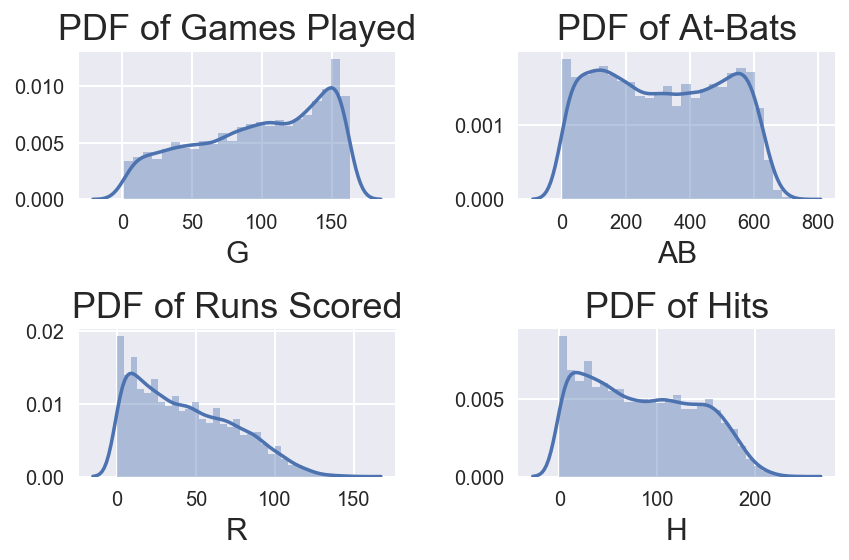

In [18]:
plt.subplot(2,2,1)
sns.distplot(df.G)
plt.title("PDF of Games Played")

plt.subplot(2,2,2)
sns.distplot(df.AB)
plt.title("PDF of At-Bats")

plt.subplot(2,2,3)
sns.distplot(df.R)
plt.title("PDF of Runs Scored")

plt.subplot(2,2,4)
sns.distplot(df.H)
plt.title("PDF of Hits")

plt.tight_layout()
plt.show()

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


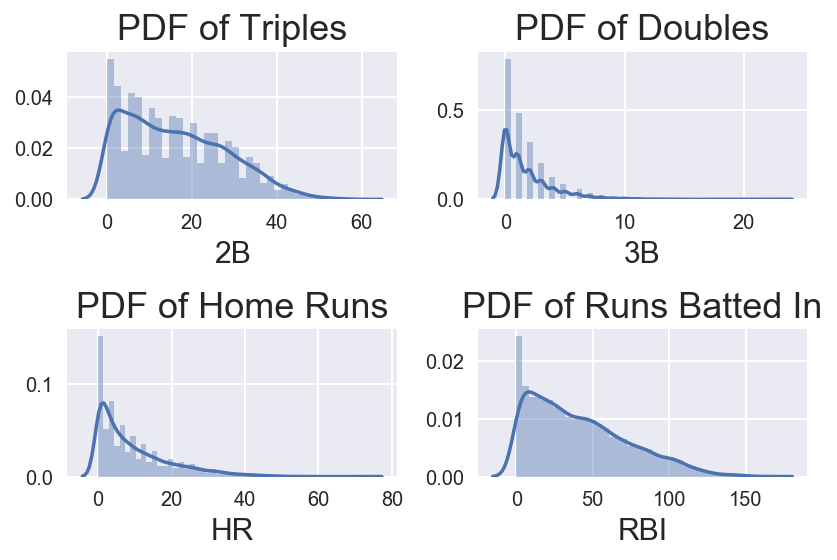

In [19]:
plt.subplot(2,2,1)
sns.distplot(df['2B'])
plt.title("PDF of Triples")

plt.subplot(2,2,2)
sns.distplot(df['3B'])
plt.title("PDF of Doubles")

plt.subplot(2,2,3)
sns.distplot(df.HR)
plt.title("PDF of Home Runs")

plt.subplot(2,2,4)
sns.distplot(df.RBI)
plt.title("PDF of Runs Batted In")

plt.tight_layout()
plt.show()

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


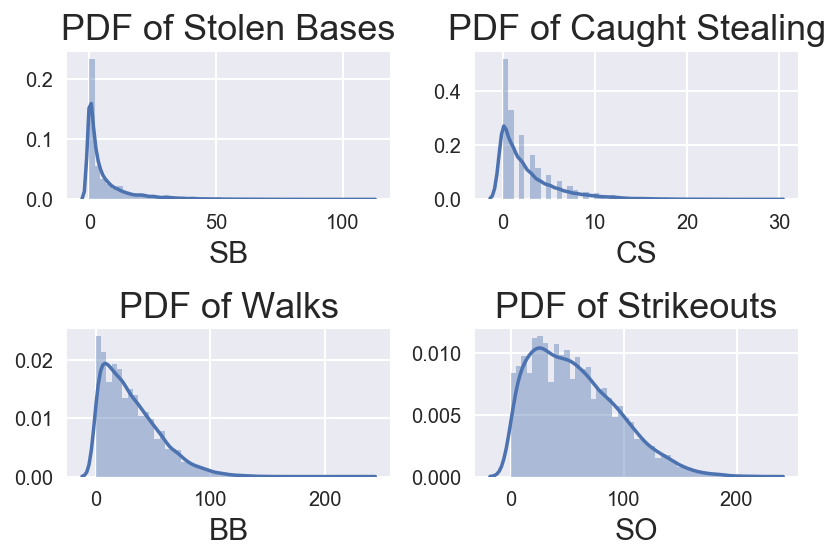

In [20]:
plt.subplot(2,2,1)
sns.distplot(df.SB)
plt.title("PDF of Stolen Bases")

plt.subplot(2,2,2)
sns.distplot(df.CS)
plt.title("PDF of Caught Stealing")

plt.subplot(2,2,3)
sns.distplot(df.BB)
plt.title("PDF of Walks")

plt.subplot(2,2,4)
sns.distplot(df.SO)
plt.title("PDF of Strikeouts")

plt.tight_layout()
plt.show()

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


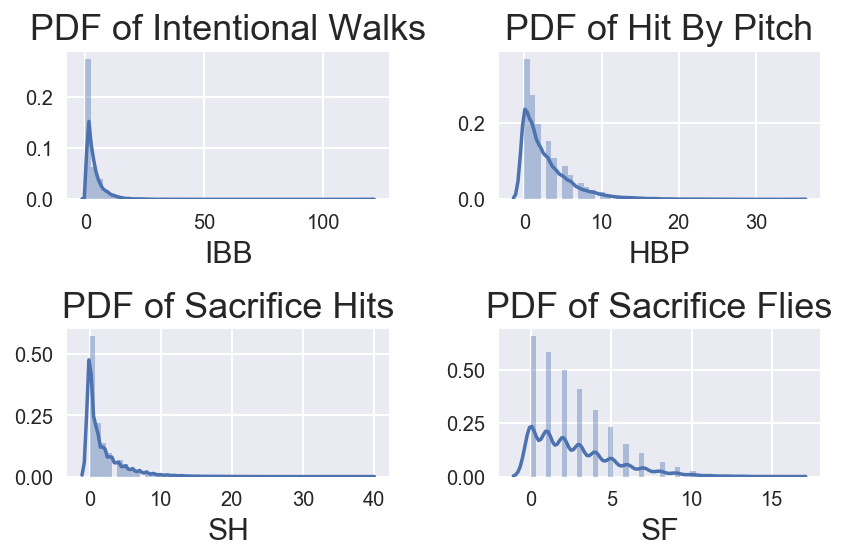

In [21]:
plt.subplot(2,2,1)
sns.distplot(df.IBB)
plt.title("PDF of Intentional Walks")

plt.subplot(2,2,2)
sns.distplot(df.HBP)
plt.title("PDF of Hit By Pitch")

plt.subplot(2,2,3)
sns.distplot(df.SH)
plt.title("PDF of Sacrifice Hits")

plt.subplot(2,2,4)
sns.distplot(df.SF)
plt.title("PDF of Sacrifice Flies")

plt.tight_layout()
plt.show()

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


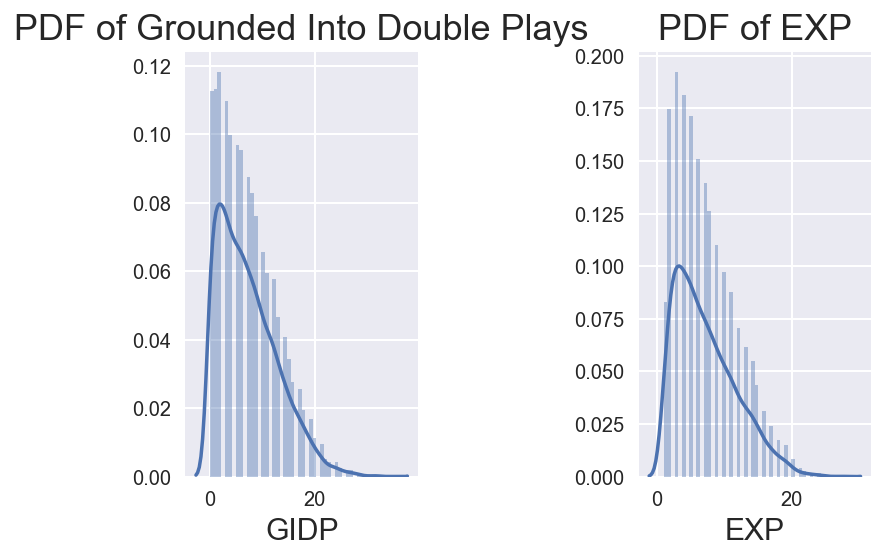

In [22]:
plt.subplot(1,2,1)
sns.distplot(df.GIDP)
plt.title("PDF of Grounded Into Double Plays")

plt.subplot(1,2,2)
sns.distplot(df.EXP)
plt.title("PDF of EXP")

plt.tight_layout()
plt.show()

Now let's look at the distribution of the target variable. We will need to adjust salary for inflation, but let's first look at the distibution of unadjusted salary, or salary in nominal terms.

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


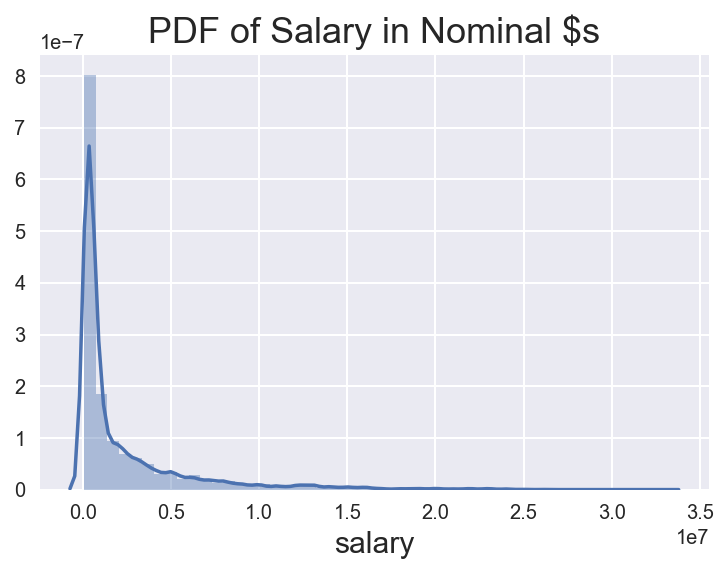

In [23]:

sns.distplot(df.salary)
plt.title("PDF of Salary in Nominal $s")

plt.show()

Plot unadjusted salary over time for the years 1985 - 2016.  Unadjusted salary is salary that is not adjusted for inflation, or is in nominal dollars.

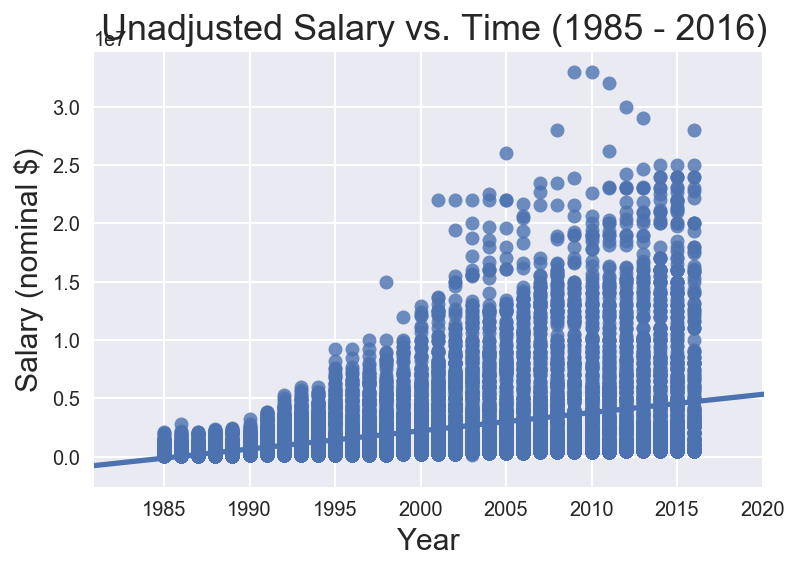

In [24]:
sns.regplot(x='yearID',
            y='salary',
           data=df)
plt.title(' Unadjusted Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (nominal $)')
plt.show()

Need to adjust salary for inflation.  For ease of interpretation, let's use 2016 dollars.  Use the CPI to calculate this.

In [25]:
cpi = pd.read_csv('CPI.csv')
cpi.head()

yearID    CPI
0    1985  107.6
1    1986  109.6
2    1987  113.6
3    1988  118.3
4    1989  124.0

Merge the salary data and cpi data by year.  Use the CPI value to adjust salary to 2016 dollars.

In [26]:
salary_adj = pd.merge(df, cpi, how='left', on='yearID')
salary_adj.describe()

yearID         stint             G            AB             R             H            2B            3B            HR           RBI            SB            CS            BB            SO           IBB           HBP            SH           SF          GIDP           EXP       allStar        salary     min_salary        is_min           CPI
count  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.00000  12395.000000  12395.000000  12395.000000  1.239500e+04   12395.000000  1.239500e+04  12395.000000
mean    2000.337959      1.006374     96.494474    314.486244     43.352723     84.273175     16.336749      1.815571      9.658733     41.398951      6.352481      2.677047     31.319645     56.940460      2.675918      2.913514      1.937797      2.71077      7.214683      7.234207      0.101170  2.267902e+06  234123.854296  2.033779e+06    175.194199
std        8.806370      0.085450     45.923603    189.707727     31.416071     56.022586     11.857439      2.311864     10.052494     31.807532      9.982408      3.351403     24.951836     38.055108      4.158929      3.481518      2.919265      2.52130      5.628885      4.548992      0.301566  3.696890e+06  151236.981636  3.644429e+06     39.323835
min     1985.000000      1.000000      1.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.00000      0.000000      1.000000      0.000000  6.000000e+04   60000.000000  0.000000e+00    107.600000
25%     1993.000000      1.000000     59.000000    144.000000     16.000000     34.000000      6.000000      0.000000      2.000000     15.000000      0.000000      0.000000     11.000000     26.000000      0.000000      0.000000      0.000000      1.00000      3.000000      4.000000      0.000000  3.000000e+05  109000.000000  3.837500e+04    144.500000
50%     2000.000000      1.000000    103.000000    310.000000     38.000000     79.000000     15.000000      1.000000      6.000000     35.000000      2.000000      2.000000     26.000000     51.000000      1.000000      2.000000      1.000000      2.00000      6.000000      6.000000      0.000000  6.250000e+05  200000.000000  4.400000e+05    172.200000
75%     2008.000000      1.000000    138.000000    484.500000     67.000000    131.000000     25.000000      3.000000     14.000000     62.000000      8.000000      4.000000     46.000000     82.000000      4.000000      4.000000      3.000000      4.00000     11.000000     10.000000      0.000000  2.550000e+06  390000.000000  2.316000e+06    214.500000
max     2016.000000      3.000000    163.000000    716.000000    152.000000    240.000000     59.000000     23.000000     73.000000    165.000000    110.000000     29.000000    232.000000    223.000000    120.000000     35.000000     39.000000     16.00000     35.000000     28.000000      1.000000  3.300000e+07  507500.000000  3.260000e+07    240.000000

In [27]:
salary_adj['salary2016'] = (240/salary_adj.CPI)*salary_adj.salary
salary_adj['min_salary2016'] =(240/salary_adj.CPI)*salary_adj.min_salary
salary_adj.head()

playerID  yearID  stint teamID lgID    G   AB   R    H  2B  3B  HR   RBI   SB   CS  BB    SO  IBB  HBP   SH   SF  GIDP     _merge  EXP  allStar   salary  min_salary  is_min    CPI    salary2016  min_salary2016
0   rosepe01    1985      1    CIN   NL  119  405  60  107  12   2   2  46.0  8.0  1.0  86  35.0  5.0  4.0  1.0  4.0  10.0  left_only   24      1.0   358858       60000  298858  107.6  8.004268e+05   133828.996283
1   rosepe01    1986      1    CIN   NL   72  237  15   52   8   2   0  25.0  3.0  0.0  30  31.0  0.0  4.0  0.0  1.0   2.0  left_only   25      0.0  1000000       60000  940000  109.6  2.189781e+06   131386.861314
2  staubru01    1985      1    NYN   NL   54   45   2   12   3   0   1   8.0  0.0  0.0  10   4.0  3.0  0.0  0.0  0.0   1.0  left_only   24      0.0   300000       60000  240000  107.6  6.691450e+05   133828.996283
3  perezto01    1985      1    CIN   NL   72  183  25   60   8   0   6  33.0  0.0  2.0  22  22.0  1.0  0.0  0.0  2.0   2.0  left_only   22      0.0   225000       60000  165000  107.6  5.018587e+05   133828.996283
4  perezto01    1986      1    CIN   NL   77  200  14   51  12   1   2  29.0  0.0  0.0  25  25.0  2.0  0.0  0.0  3.0   6.0  left_only   23      0.0   275000       60000  215000  109.6  6.021898e+05   131386.861314

No we can look at the distribution and scatter plot over time for salary in constant 2016 dollars.

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


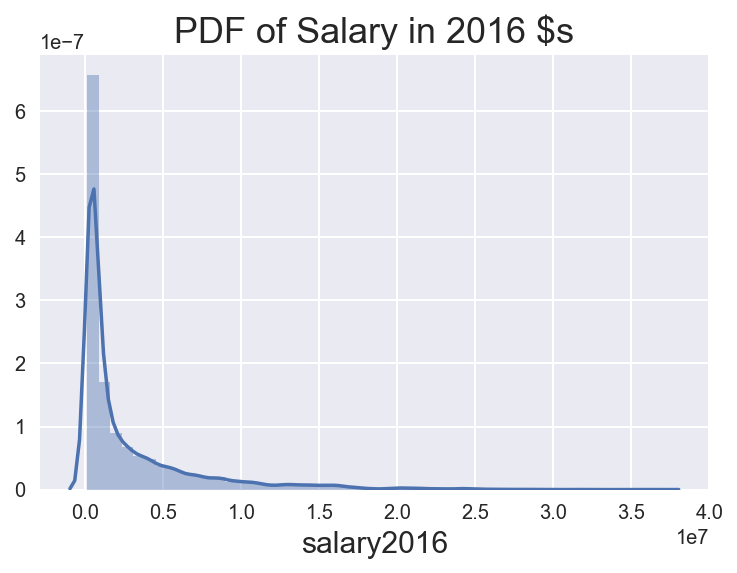

In [28]:
sns.distplot(salary_adj.salary2016)
plt.title("PDF of Salary in 2016 $s")

plt.show()

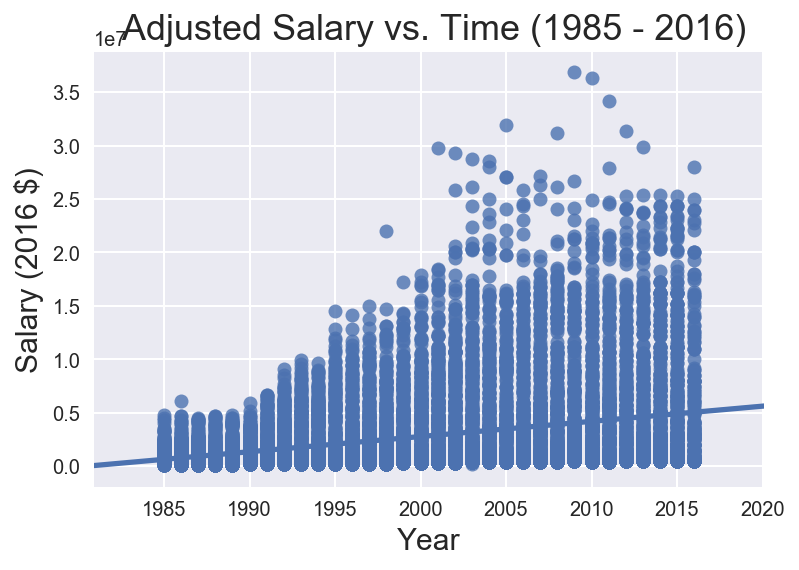

In [29]:
sns.regplot(x='yearID',
            y='salary2016',
           data=salary_adj)
plt.title(' Adjusted Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (2016 $)')
plt.show()

Considering the salary data is heavily skewed to the right, we will want to use the log of salary instead.  Let's look at that ditribution.

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


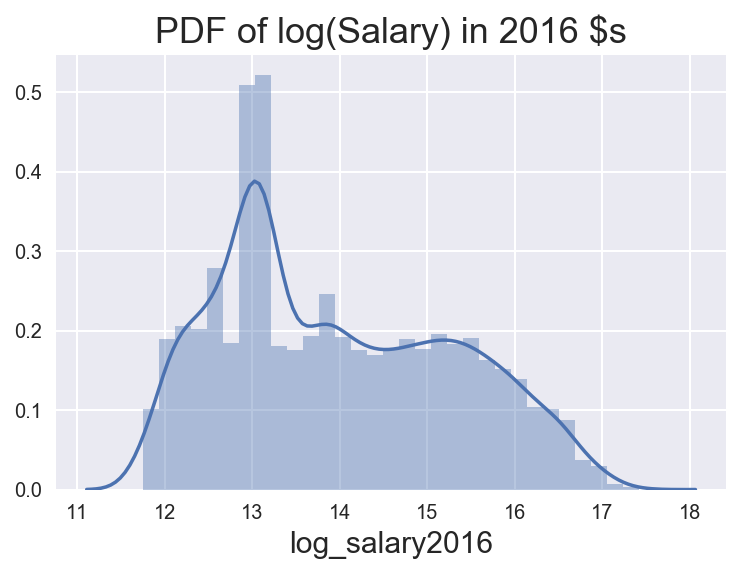

In [30]:
salary_adj['log_salary2016'] = np.log(salary_adj['salary2016'])
sns.distplot(salary_adj.log_salary2016)
plt.title("PDF of log(Salary) in 2016 $s")

plt.show()

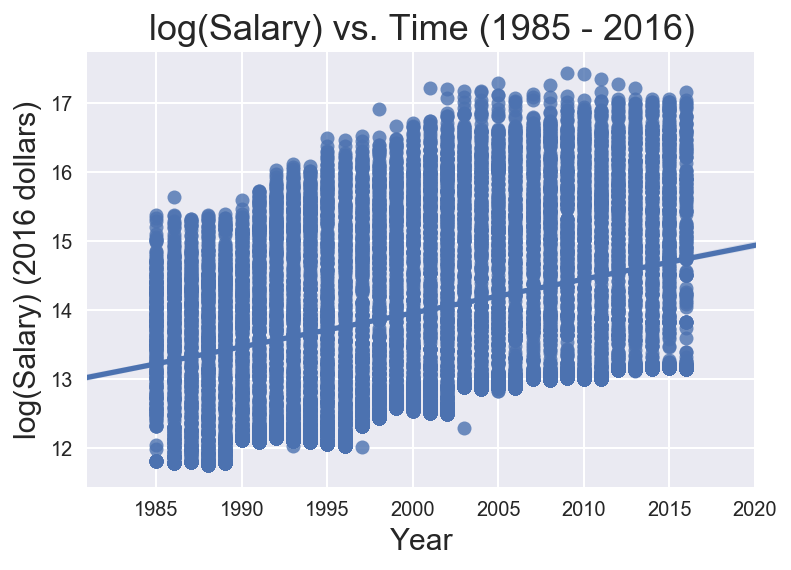

In [31]:
sns.regplot(x='yearID',
            y='log_salary2016',
           data=salary_adj)
plt.title('log(Salary) vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

Let's look at a pairplot with some of the more important features.


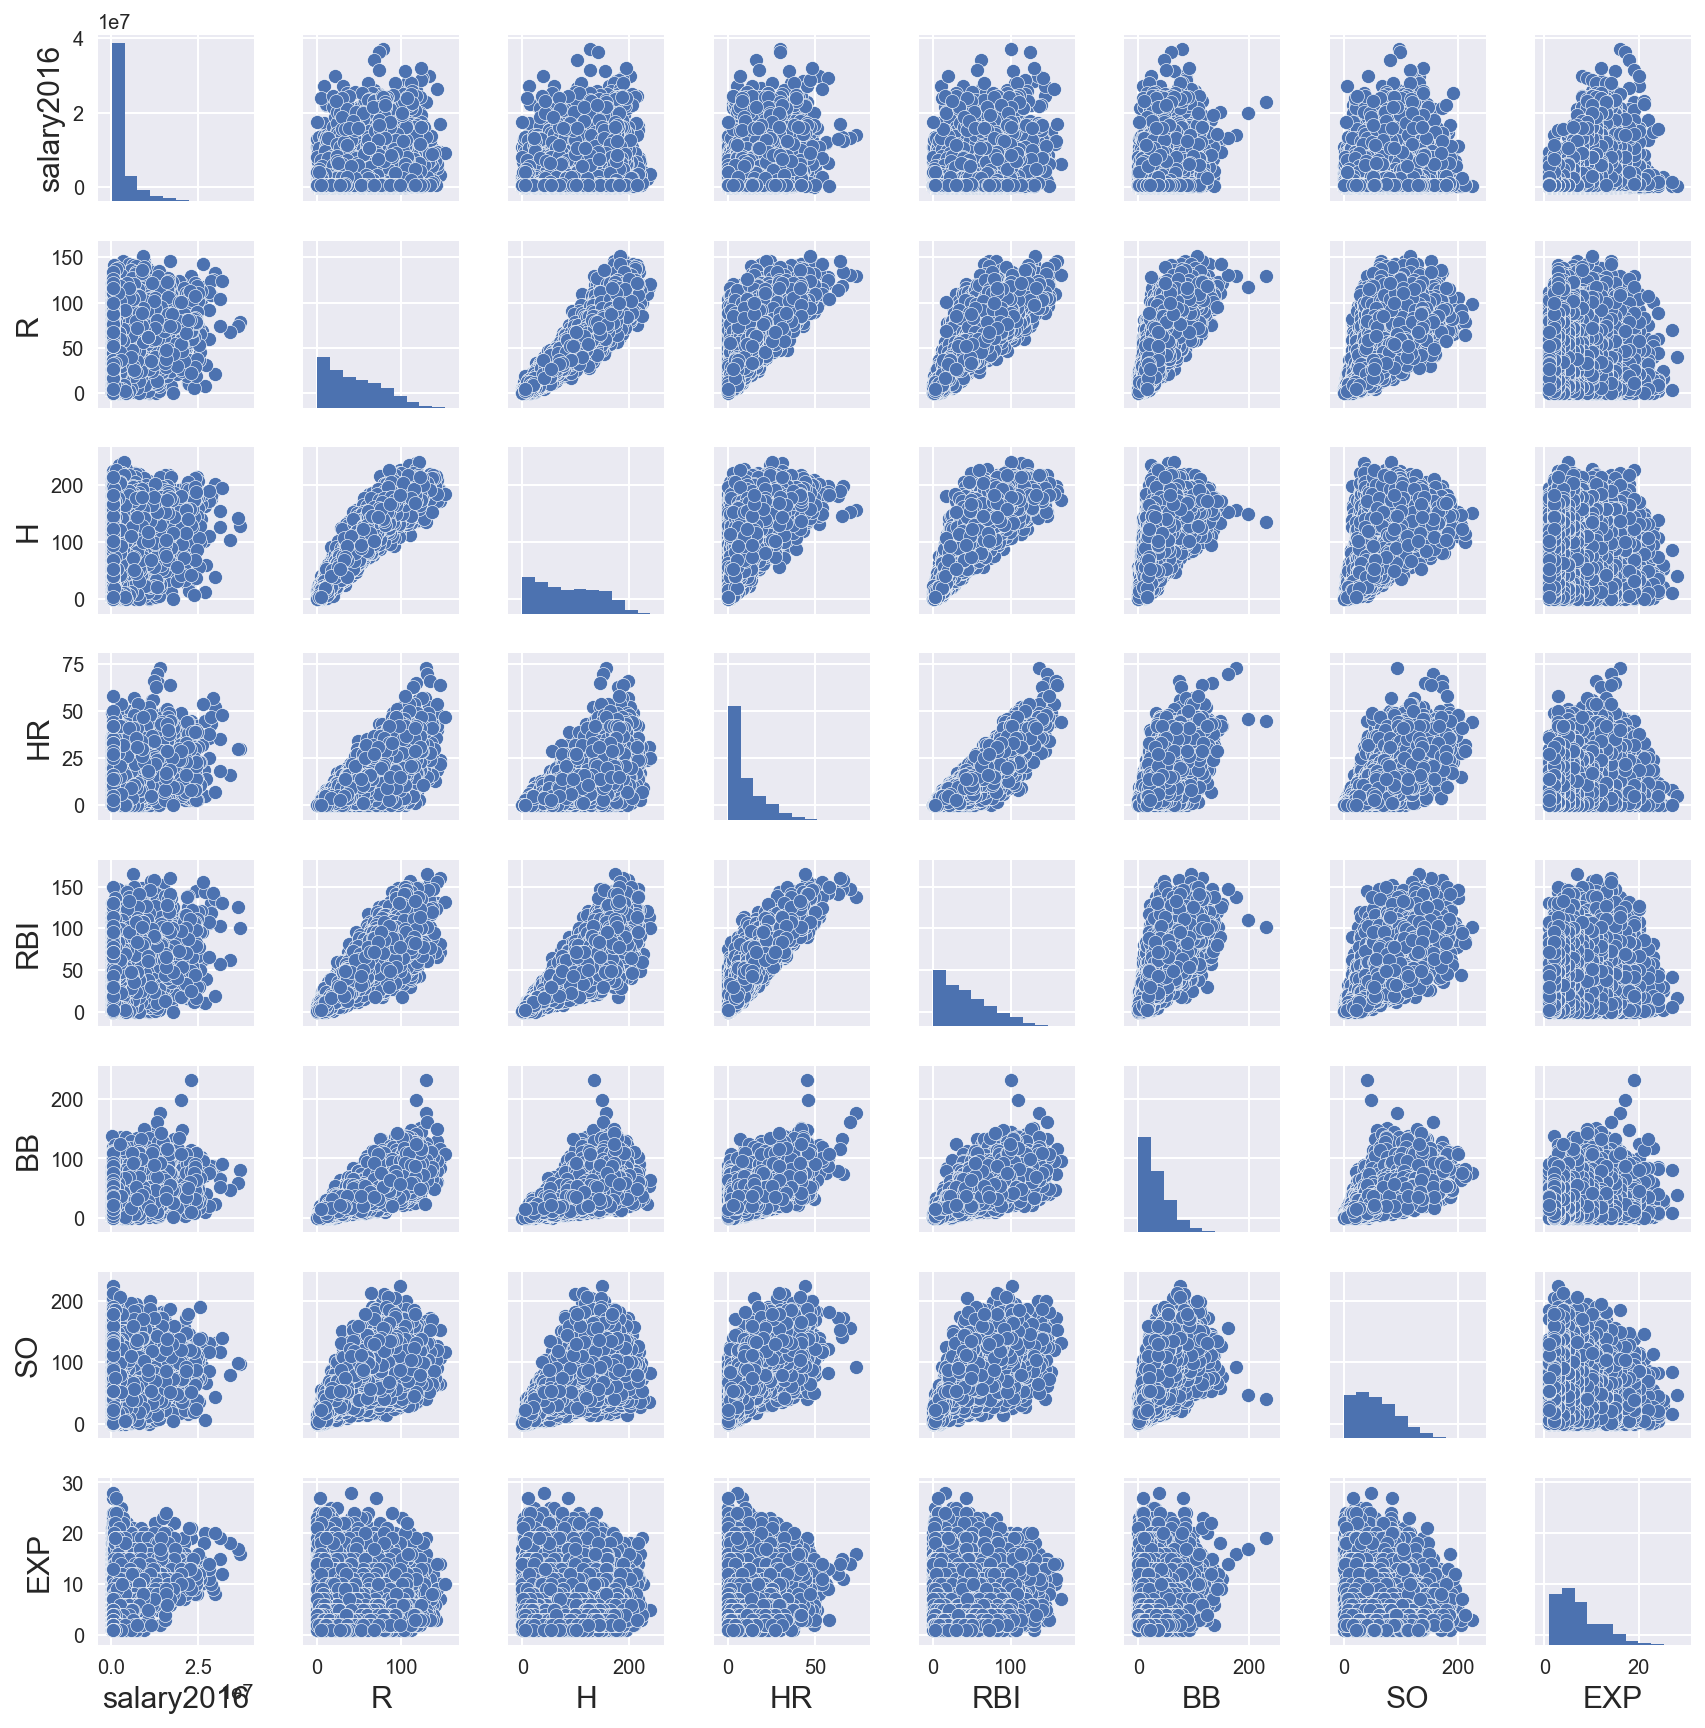

In [32]:
cols = ['salary2016', 'R', 'H', 'HR', 'RBI', 'BB', 'SO', 'EXP']
sns.pairplot(salary_adj[cols], size = 1.5)

plt.show()

In [33]:
corr = salary_adj[cols].corr()
corr.style.background_gradient().set_precision(2)

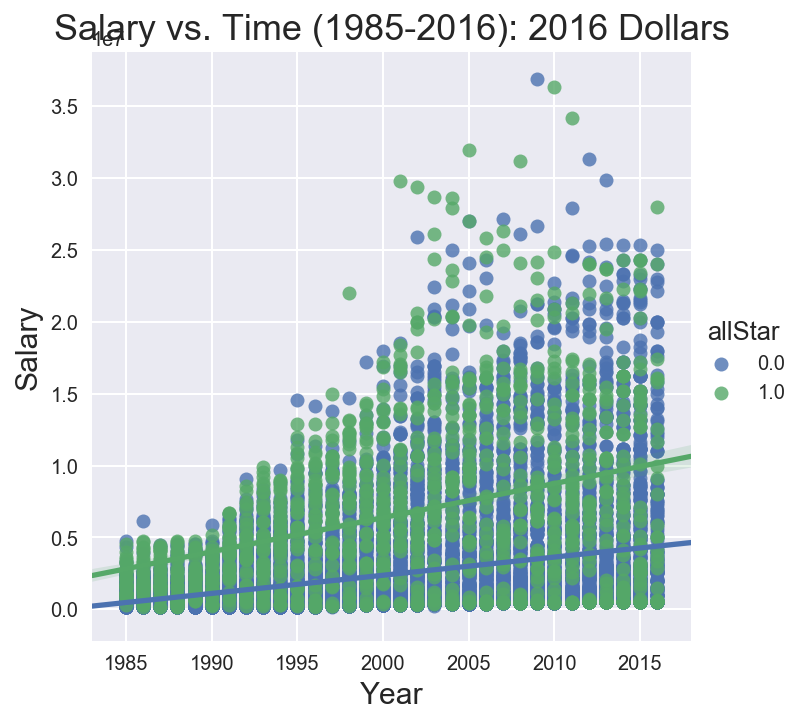

In [34]:
sns.lmplot(x='yearID',
            y='salary2016',
            hue = 'allStar',
            data=salary_adj)
plt.title('Salary vs. Time (1985-2016): 2016 Dollars')
plt.ylabel('Salary')
plt.xlabel('Year')
plt.show()

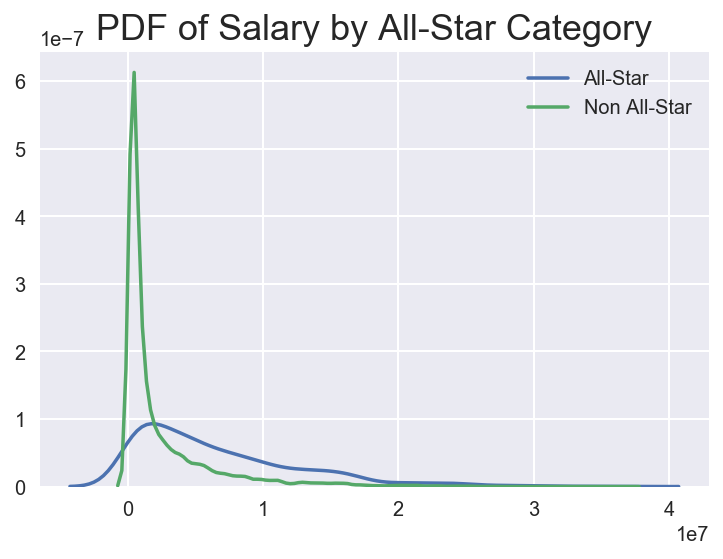

In [35]:
all_star_on = salary_adj[salary_adj.allStar == 1]
all_star_off = salary_adj[salary_adj.allStar == 0]

sns.kdeplot(all_star_on.salary2016, label="All-Star")
sns.kdeplot(all_star_off.salary2016, label="Non All-Star")
plt.title("PDF of Salary by All-Star Category")
plt.show()

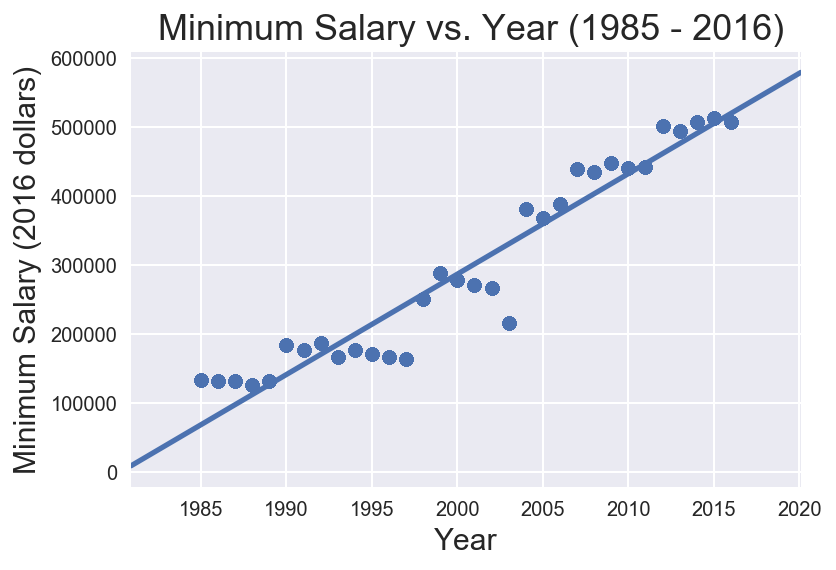

In [36]:
sns.regplot(x='yearID',
            y='min_salary2016',
           data=salary_adj)
plt.title(' Minimum Salary vs. Year (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Minimum Salary (2016 dollars)')
plt.show()

In [37]:
top_salary = salary_adj.nlargest(20, 'salary2016')
top_paid = top_salary.playerID.unique()
top_paid



array(['rodrial01', 'ramirma02', 'cabremi01', 'wellsve01', 'giambja01',
       'bondsba01'], dtype=object)

In [38]:
top_paid_players = salary_adj[salary_adj.playerID.isin(['rodrial01', 'ramirma02', 'cabremi01', 'wellsve01', 'giambja01',
       'bondsba01'])]
top_paid_players.head()

playerID  yearID  stint teamID lgID    G   AB    R    H  2B  3B  HR    RBI    SB    CS  BB     SO   IBB  HBP   SH   SF  GIDP     _merge  EXP  allStar  salary  min_salary  is_min    CPI    salary2016  min_salary2016  log_salary2016
2341  bondsba01    1986      1    PIT   NL  113  413   72   92  26   3  16   48.0  36.0   7.0  65  102.0   2.0  2.0  2.0  2.0   4.0  left_only    1      0.0   60000       60000       0  109.6  1.313869e+05   131386.861314       11.785901
2342  bondsba01    1987      1    PIT   NL  150  551   99  144  34   9  25   59.0  32.0  10.0  54   88.0   3.0  3.0  0.0  3.0   4.0  left_only    2      0.0  100000       62500   37500  113.6  2.112676e+05   132042.253521       12.260881
2343  bondsba01    1988      1    PIT   NL  144  538   97  152  30   5  24   58.0  17.0  11.0  72   82.0  14.0  2.0  0.0  2.0   3.0  left_only    3      0.0  220000       62500  157500  118.3  4.463229e+05   126796.280642       13.008798
2344  bondsba01    1989      1    PIT   NL  159  580   96  144  34   6  19   58.0  32.0  10.0  93   93.0  22.0  1.0  1.0  4.0   9.0  left_only    4      0.0  360000       68000  292000  124.0  6.967742e+05   131612.903226       13.454217
2345  bondsba01    1990      1    PIT   NL  151  519  104  156  32   3  33  114.0  52.0  13.0  93   83.0  15.0  3.0  0.0  6.0   8.0  left_only    5      1.0  850000      100000  750000  130.7  1.560826e+06   183626.625861       14.260726

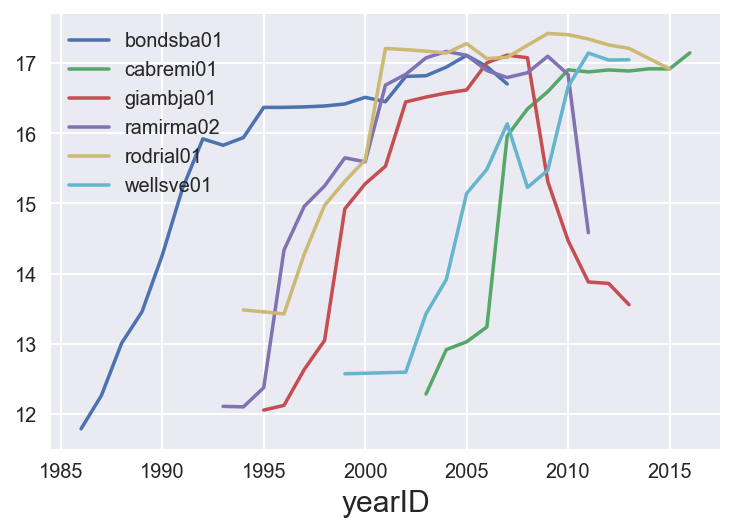

In [39]:
top_paid_players.set_index('yearID', inplace=True)
top_paid_players.groupby('playerID')['log_salary2016'].plot(legend=True)
plt.show()

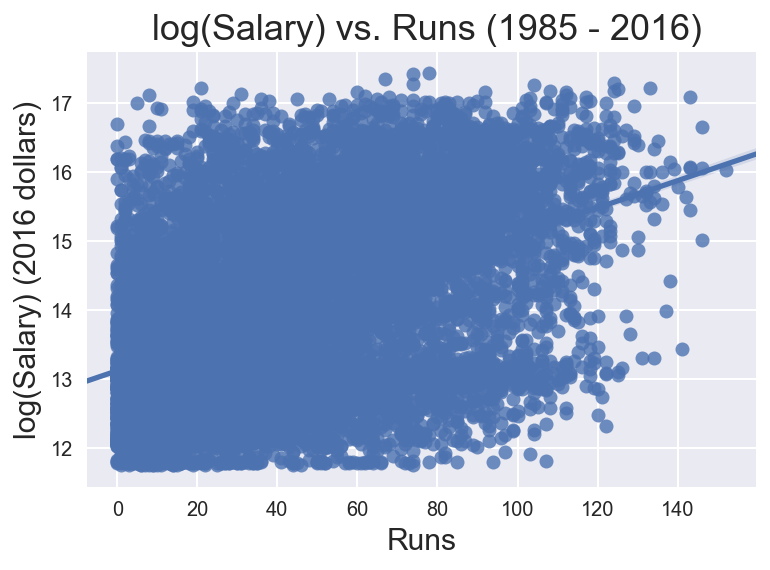

In [40]:
sns.regplot(x='R',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Runs (1985 - 2016)')
plt.xlabel('Runs')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

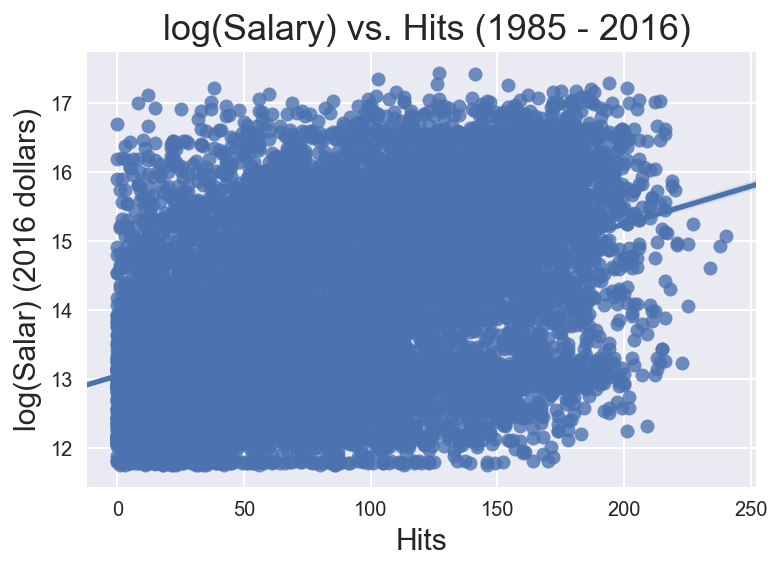

In [41]:
sns.regplot(x='H',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Hits (1985 - 2016)')
plt.xlabel('Hits')
plt.ylabel('log(Salar) (2016 dollars)')
plt.show()

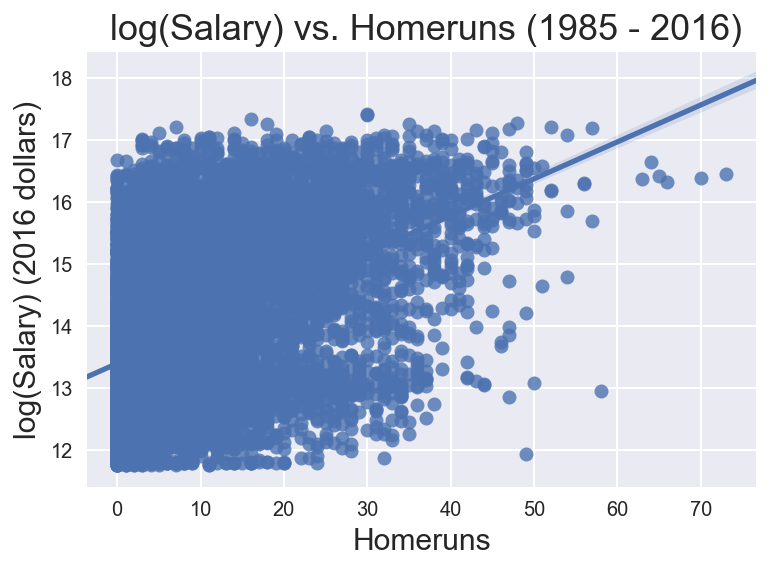

In [42]:
sns.regplot(x='HR',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Homeruns (1985 - 2016)')
plt.xlabel('Homeruns')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

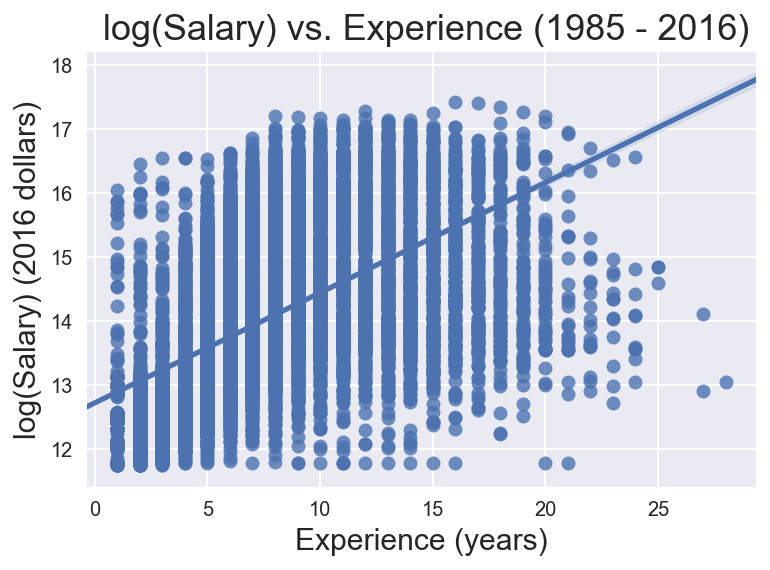

In [43]:
sns.regplot(x='EXP',
            y='log_salary2016',
           data=salary_adj)
plt.title(' log(Salary) vs. Experience (1985 - 2016)')
plt.xlabel('Experience (years)')
plt.ylabel('log(Salary) (2016 dollars)')
plt.show()

## IV. Feature Engineering

Create a batting average feature, which is simply the number hits a player has divided by the number of at-bats.  Al

In [44]:
salary_adj['AVG'] = salary_adj.H / salary_adj.AB *1000
salary_adj['EXP_SQ']=np.square(salary_adj['EXP'])

# salary_adj.sort_values(by=['playerID', 'yearID'])

salary_adj.describe()


yearID         stint             G            AB             R             H            2B            3B            HR           RBI            SB            CS            BB            SO           IBB           HBP            SH           SF          GIDP           EXP       allStar        salary     min_salary        is_min           CPI    salary2016  min_salary2016  log_salary2016           AVG        EXP_SQ
count  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.00000  12395.000000  12395.000000  12395.000000  1.239500e+04   12395.000000  1.239500e+04  12395.000000  1.239500e+04    12395.000000    12395.000000  12395.000000  12395.000000
mean    2000.337959      1.006374     96.494474    314.486244     43.352723     84.273175     16.336749      1.815571      9.658733     41.398951      6.352481      2.677047     31.319645     56.940460      2.675918      2.913514      1.937797      2.71077      7.214683      7.234207      0.101170  2.267902e+06  234123.854296  2.033779e+06    175.194199  2.827202e+06   291864.766089       13.969378    251.966263     73.025413
std        8.806370      0.085450     45.923603    189.707727     31.416071     56.022586     11.857439      2.311864     10.052494     31.807532      9.982408      3.351403     24.951836     38.055108      4.158929      3.481518      2.919265      2.52130      5.628885      4.548992      0.301566  3.696890e+06  151236.981636  3.644429e+06     39.323835  4.194567e+06   134201.742861        1.331716     55.353033     86.533897
min     1985.000000      1.000000      1.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.00000      0.000000      1.000000      0.000000  6.000000e+04   60000.000000  0.000000e+00    107.600000  1.267963e+05   126796.280642       11.750337      0.000000      1.000000
25%     1993.000000      1.000000     59.000000    144.000000     16.000000     34.000000      6.000000      0.000000      2.000000     15.000000      0.000000      0.000000     11.000000     26.000000      0.000000      0.000000      0.000000      1.00000      3.000000      4.000000      0.000000  3.000000e+05  109000.000000  3.837500e+04    144.500000  4.104167e+05   171653.543307       12.924928    230.215827     16.000000
50%     2000.000000      1.000000    103.000000    310.000000     38.000000     79.000000     15.000000      1.000000      6.000000     35.000000      2.000000      2.000000     26.000000     51.000000      1.000000      2.000000      1.000000      2.00000      6.000000      6.000000      0.000000  6.250000e+05  200000.000000  4.400000e+05    172.200000  9.408411e+05   266814.897165       13.754529    258.196721     36.000000
75%     2008.000000      1.000000    138.000000    484.500000     67.000000    131.000000     25.000000      3.000000     14.000000     62.000000      8.000000      4.000000     46.000000     82.000000      4.000000      4.000000      3.000000      4.00000     11.000000     10.000000      0.000000  2.550000e+06  390000.000000  2.316000e+06    214.500000  3.521443e+06   439942.112880       15.074381    283.161219    100.000000
max     2016.000000      3.000000    163.000000    716.000000    152.000000    240.000000     59.000000     23.000000     73.000000    165.000000    110.000000     29.000000    232.000000    223.000000    120.000000     35.000000     39.000000     16.00000     35.000000     28.000000      1.000000  3.300000e+07  507500.000000  3.260000e+07    240.000000  3.692308e+07   513924.050633       17.424347   1000.000000    784.000000

Creating lagged values of the target variable and lagged values of the features.  This is based on the idea that salary is based off of past performance.

In [45]:
# lagged values of salary
salary_adj['sal_t_1'] = salary_adj.groupby(['playerID'])['salary2016'].shift(1)
salary_adj['sal_t_2'] = salary_adj.groupby(['playerID'])['salary2016'].shift(2)
salary_adj['sal_t_3'] = salary_adj.groupby(['playerID'])['salary2016'].shift(3)

# first difference of salary lagged one period
salary_adj['sal_diff'] = salary_adj.salary2016 - salary_adj.sal_t_1
salary_adj['sal_diff_t_1'] = salary_adj.groupby(['playerID'])['sal_diff'].shift(1)

# lagged values of the features
salary_adj['G_t_1'] = salary_adj.groupby(['playerID'])['G'].shift(1)
salary_adj['G_t_2'] = salary_adj.groupby(['playerID'])['G'].shift(2)

salary_adj['AB_t_1'] = salary_adj.groupby(['playerID'])['AB'].shift(1)
salary_adj['AB_t_2'] = salary_adj.groupby(['playerID'])['AB'].shift(2)

salary_adj['R_t_1'] = salary_adj.groupby(['playerID'])['R'].shift(1)
salary_adj['R_t_2'] = salary_adj.groupby(['playerID'])['R'].shift(2)

salary_adj['H_t_1'] = salary_adj.groupby(['playerID'])['H'].shift(1)
salary_adj['H_t_2'] = salary_adj.groupby(['playerID'])['H'].shift(2)

salary_adj['2B_t_1'] = salary_adj.groupby(['playerID'])['2B'].shift(1)
salary_adj['2B_t_2'] = salary_adj.groupby(['playerID'])['2B'].shift(2)

salary_adj['3B_t_1'] = salary_adj.groupby(['playerID'])['3B'].shift(1)
salary_adj['3B_t_2'] = salary_adj.groupby(['playerID'])['3B'].shift(2)

salary_adj['HR_t_1'] = salary_adj.groupby(['playerID'])['HR'].shift(1)
salary_adj['HR_t_2'] = salary_adj.groupby(['playerID'])['HR'].shift(2)

salary_adj['RBI_t_1'] = salary_adj.groupby(['playerID'])['RBI'].shift(1)
salary_adj['RBI_t_2'] = salary_adj.groupby(['playerID'])['RBI'].shift(2)

salary_adj['AVG_t_1'] = salary_adj.groupby(['playerID'])['AVG'].shift(1)
salary_adj['AVG_t_2'] = salary_adj.groupby(['playerID'])['AVG'].shift(2)

salary_adj['SB_t_1'] = salary_adj.groupby(['playerID'])['SB'].shift(1)
salary_adj['SB_t_2'] = salary_adj.groupby(['playerID'])['SB'].shift(2)

salary_adj['CS_t_1'] = salary_adj.groupby(['playerID'])['CS'].shift(1)
salary_adj['CS_t_2'] = salary_adj.groupby(['playerID'])['CS'].shift(2)

salary_adj['BB_t_1'] = salary_adj.groupby(['playerID'])['BB'].shift(1)
salary_adj['BB_t_2'] = salary_adj.groupby(['playerID'])['BB'].shift(2)

salary_adj['SO_t_1'] = salary_adj.groupby(['playerID'])['SO'].shift(1)
salary_adj['SO_t_2'] = salary_adj.groupby(['playerID'])['SO'].shift(2)

salary_adj['IBB_t_1'] = salary_adj.groupby(['playerID'])['IBB'].shift(1)
salary_adj['IBB_t_2'] = salary_adj.groupby(['playerID'])['IBB'].shift(2)

salary_adj['HBP_t_1'] = salary_adj.groupby(['playerID'])['HBP'].shift(1)
salary_adj['HBP_t_2'] = salary_adj.groupby(['playerID'])['HBP'].shift(2)

salary_adj['SH_t_1'] = salary_adj.groupby(['playerID'])['SH'].shift(1)
salary_adj['SH_t_2'] = salary_adj.groupby(['playerID'])['SH'].shift(2)

salary_adj['SF_t_1'] = salary_adj.groupby(['playerID'])['SF'].shift(1)
salary_adj['SF_t_2'] = salary_adj.groupby(['playerID'])['SF'].shift(2)

salary_adj['GIDP_t_1'] = salary_adj.groupby(['playerID'])['GIDP'].shift(1)
salary_adj['GIDP_t_2'] = salary_adj.groupby(['playerID'])['GIDP'].shift(2)

salary_adj['allStar_t_1'] = salary_adj.groupby(['playerID'])['allStar'].shift(1)
salary_adj['allStar_t_2'] = salary_adj.groupby(['playerID'])['allStar'].shift(2)
#salary_adj.sort_values(by=['playerID', 'yearID'])

On Base Percentage (aka OBP, On Base Average, OBA) is a measure of how often a batter reaches base. It is approximately equal to Times on Base/Plate appearances.

The full formula is OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies). Batters are not credited with reaching base on an error or fielder's choice, and they are not charged with an opportunity if they make a sacrifice bunt.

In [46]:
salary_adj['OBP'] = 1000*(salary_adj.H + salary_adj.BB + salary_adj.HBP)/(salary_adj.AB + salary_adj.BB + salary_adj.HBP
                                                                    + salary_adj.SF)

# Create lagged value of OBP
salary_adj['OBP_t_1'] = salary_adj.groupby(['playerID'])['OBP'].shift(1)
salary_adj['OBP_t_2'] = salary_adj.groupby(['playerID'])['OBP'].shift(2)

In [47]:
salary_adj['exp_runs'] = salary_adj.EXP*salary_adj.R
salary_adj['exp_AVG'] = salary_adj.EXP*salary_adj.AVG
salary_adj['exp_HR'] = salary_adj.EXP*salary_adj.HR
salary_adj['exp_OBP'] = salary_adj.EXP*salary_adj.OBP
salary_adj['exp_H'] = salary_adj.EXP*salary_adj.H
salary_adj['exp_RBI'] = salary_adj.EXP*salary_adj.RBI
salary_adj['exp_SO'] = salary_adj.EXP*salary_adj.SO


salary_adj['constant'] = 1

In [48]:
salary_adj.describe()

yearID         stint             G            AB             R             H            2B            3B            HR           RBI            SB            CS            BB            SO           IBB           HBP            SH           SF          GIDP           EXP       allStar        salary     min_salary        is_min           CPI    salary2016  min_salary2016  log_salary2016           AVG        EXP_SQ       sal_t_1       sal_t_2       sal_t_3      sal_diff  \
count  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.000000  12395.00000  12395.000000  12395.000000  12395.000000  1.239500e+04   12395.000000  1.239500e+04  12395.000000  1.239500e+04    12395.000000    12395.000000  12395.000000  12395.000000  1.015600e+04  8.394000e+03  6.936000e+03  1.015600e+04   
mean    2000.337959      1.006374     96.494474    314.486244     43.352723     84.273175     16.336749      1.815571      9.658733     41.398951      6.352481      2.677047     31.319645     56.940460      2.675918      2.913514      1.937797      2.71077      7.214683      7.234207      0.101170  2.267902e+06  234123.854296  2.033779e+06    175.194199  2.827202e+06   291864.766089       13.969378    251.966263     73.025413  2.981153e+06  3.018058e+06  2.983965e+06  3.655786e+05   
std        8.806370      0.085450     45.923603    189.707727     31.416071     56.022586     11.857439      2.311864     10.052494     31.807532      9.982408      3.351403     24.951836     38.055108      4.158929      3.481518      2.919265      2.52130      5.628885      4.548992      0.301566  3.696890e+06  151236.981636  3.644429e+06     39.323835  4.194567e+06   134201.742861        1.331716     55.353033     86.533897  4.266172e+06  4.283810e+06  4.254691e+06  1.876714e+06   
min     1985.000000      1.000000      1.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.00000      0.000000      1.000000      0.000000  6.000000e+04   60000.000000  0.000000e+00    107.600000  1.267963e+05   126796.280642       11.750337      0.000000      1.000000  1.267963e+05  1.267963e+05  1.267963e+05 -2.164086e+07   
25%     1993.000000      1.000000     59.000000    144.000000     16.000000     34.000000      6.000000      0.000000      2.000000     15.000000      0.000000      0.000000     11.000000     26.000000      0.000000      0.000000      0.000000      1.00000      3.000000      4.000000      0.000000  3.000000e+05  109000.000000  3.837500e+04    144.500000  4.104167e+05   171653.543307       12.924928    230.215827     16.000000  4.108696e+05  4.005978e+05  3.903288e+05 -5.873894e+02   
50%     2000.000000      1.000000    103.000000    310.000000     38.000000     79.000000     15.000000      1.000000      6.000000     35.000000      2.000000      2.000000     26.000000     51.000000      1.000000      2.000000      1.000000      2.00000      6.000000      6.000000      0.000000  6.250000e+05  200000.000000  4.400000e+05    172.200000  9.408411e+05   266814.897165       13.754529    258.196721     36.000000  1.055853e+06  1.065072e+06  1.033206e+06  1.168450e+05   
75%     2008.000000      1.000000    138.000000    484.500000     67.000000    131.000000     25.000000      3.000000     14.000000     62.000000      8.000000      4.000000     46.000000     82.000000      4.000000      4.000000      3.000000      4.00000     11.000000     10.000000      0.000000  2.550000e+06  390000.000000  2.316000e+06    214.500000  3.521443e+06   439942.112880       15.074381    283.161219    100.000000  3.870968e+06  4.004522e+06  4.002990e+06  7.989311e+05   
max     2016.000000      3.000000    163.000000    716.000000    152.000000    240.000000     59.0000

## V. Modeling and Results

In [49]:
y = salary_adj.log_salary2016
x_baseline = salary_adj[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SF', 'SH',
               'GIDP', 'AVG', 'OBP', 'constant']]

x_ols_exp = salary_adj[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SB', 'CS', 'SO', 'IBB', 'HBP', 'SF', 'SH',
               'GIDP', 'AVG', 'OBP', 'EXP', 'EXP_SQ', 'allStar', 'constant']]



x_lag1 = salary_adj[['sal_t_1', 'G_t_1', 'AB_t_1', 'R_t_1', 
                'H_t_1', '2B_t_1', '3B_t_1', 'HR_t_1',
                'RBI_t_1', 'SB_t_1', 'CS_t_1', 'BB_t_1', 'SO_t_1', 
                'IBB_t_1', 'HBP_t_1', 'SH_t_1', 'SF_t_1',
                'GIDP_t_1', 'AVG_t_1',
                'OBP_t_1', 'EXP', 'EXP_SQ', 'allStar_t_1', 'min_salary2016', 'constant']]

# remove the features that have a feature importance of 30 and below
x = salary_adj[['sal_t_1','sal_t_2', #'sal_t_3',
                'min_salary2016',
                'EXP', 'EXP_SQ',# experience or years in the league
                'R_t_1', 'R_t_2',
                #'H_t_1', 'H_t_2',
                'HR_t_1','HR_t_2',
                #'RBI_t_1', 'RBI_t_2',
                'SO_t_1', 'SO_t_2',
                #'AVG_t_1', 'AVG_t_2',
                #'BB_t_1', 'BB_t_2',
                'OBP_t_1', 'OBP_t_2',
                'allStar_t_1',
                'exp_runs',
                'exp_OBP',
                'exp_H', 'constant']]

Create the training and test splits.

In [50]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(x_baseline, y, test_size=.25, random_state=1234)

In [51]:
X_train_ols_exp, X_test_ols_exp, y_train_ols_exp, y_test_ols_exp = train_test_split(x_ols_exp,
                                                                                    y,
                                                                                    test_size=.25,
                                                                                    random_state=1)

In [52]:
X_train_lag1, X_test_lag1, y_train_lag1, y_test_lag1 = train_test_split(x_lag1, y, test_size=.25, random_state=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=66)


In [54]:
X_train.head()

sal_t_1       sal_t_2  min_salary2016  EXP  EXP_SQ  R_t_1  R_t_2  HR_t_1  HR_t_2  SO_t_1  SO_t_2     OBP_t_1     OBP_t_2  allStar_t_1  exp_runs      exp_OBP  exp_H  constant
9429   2.202381e+06  1.142857e+06   439942.112880    7      49   53.0   62.0    16.0    18.0    85.0   107.0  350.543478  332.589286          0.0       588  2482.195846   1092         1
7618   8.847926e+06  1.778719e+07   389285.714286   10     100   38.0   32.0     8.0     9.0    35.0    22.0  358.600583  351.351351          0.0       820  3498.452012   1770         1
4436   2.392523e+06  1.682600e+06   250306.748466    9      81   59.0   85.0     2.0     5.0    64.0    98.0  359.139785  384.012539          0.0       918  3628.005658   1719         1
6267   2.542056e+05  1.912046e+05   250306.748466    5      25    9.0   12.0     1.0     1.0    28.0    22.0  261.437908  267.515924          0.0         0  1111.111111     10         1
10454  1.596567e+07  1.567944e+07   506970.849176   11     121   62.0   49.0    20.0    14.0    52.0    72.0  401.785714  321.518987          0.0       704  4060.546875   1397         1

In [55]:
X_base_train.describe()

G           AB            R            H           2B           3B           HR          RBI           SB           CS           BB           SO          IBB          HBP           SF           SH         GIDP          AVG          OBP  constant
count  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000  9296.000000    9296.0
mean     96.483326   314.278722    43.343804    84.173515    16.314544     1.832401     9.663511    41.385757     6.312070     2.680615    31.270116    56.799914     2.661252     2.906411     2.711166     1.977194     7.202560   251.860252   319.370145       1.0
std      45.927371   189.692655    31.368238    55.962441    11.800540     2.330906    10.032296    31.750721     9.850249     3.317756    25.043825    37.841136     4.216368     3.485628     2.536733     2.980791     5.606743    56.292784    62.790067       0.0
min       1.000000     1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       1.0
25%      59.000000   144.750000    16.000000    34.000000     6.000000     0.000000     2.000000    15.000000     0.000000     0.000000    11.000000    26.000000     0.000000     0.000000     1.000000     0.000000     3.000000   230.031949   293.185190       1.0
50%     103.000000   309.000000    38.000000    79.000000    15.000000     1.000000     6.000000    35.000000     2.000000     2.000000    26.000000    51.000000     1.000000     2.000000     2.000000     1.000000     6.000000   257.950530   324.225416       1.0
75%     138.000000   484.000000    67.000000   131.000000    25.000000     3.000000    14.000000    62.000000     8.000000     4.000000    45.000000    82.000000     3.000000     4.000000     4.000000     3.000000    11.000000   283.185841   353.922576       1.0
max     163.000000   716.000000   152.000000   240.000000    59.000000    23.000000    73.000000   165.000000   110.000000    28.000000   232.000000   211.000000   120.000000    35.000000    16.000000    39.000000    32.000000  1000.000000  1000.000000       1.0

### Linear Regression Models

In [56]:

#X_base_train['const'] = 1
#X_base_test['const'] = 1
#X_train_ols_exp['const'] = 1
#X_test_ols_exp['const'] = 1
#X_train_lag1['const'] = 1
#X_test_lag1['const'] = 1
#X_train['const'] = 1
#X_test['const'] = 1

In [57]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
model_linear.fit(X_base_train, y_base_train)
model_linear.score(X_base_train, y_base_train)

0.33020811657828264

In [58]:
reg1 = sm.OLS(y_base_train, X_base_train, missing='drop')
results = reg1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     240.7
Date:                Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:12:18   Log-Likelihood:                -14010.
No. Observations:                9296   AIC:                         2.806e+04
Df Residuals:                    9276   BIC:                         2.820e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G             -0.0154      0.001    -17.571      0.0

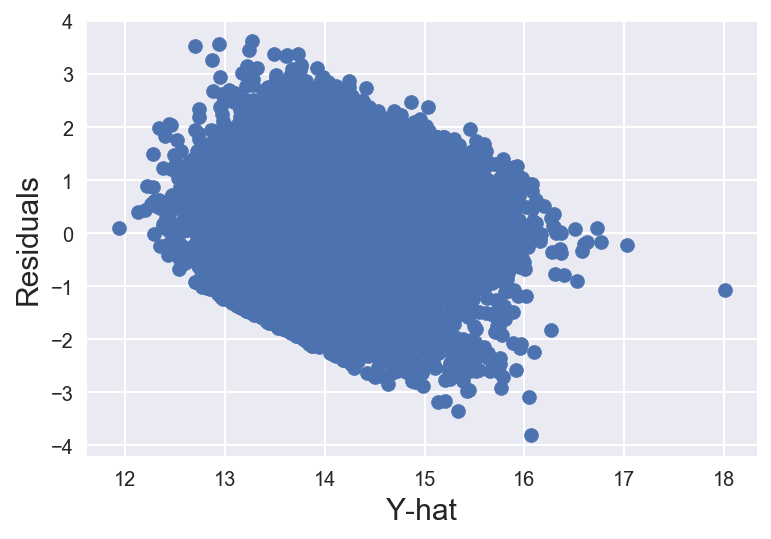

In [59]:
y_pred_base_train = model_linear.predict(X_base_train)
residual_base_train = y_base_train - y_pred_base_train
plt.scatter(y_pred_base_train, residual_base_train)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

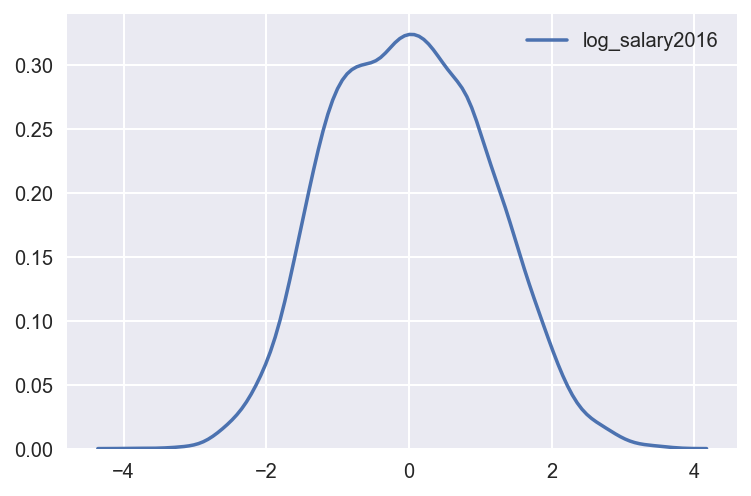

In [60]:
sns.kdeplot(residual_base_train)
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(y_base_train, y_pred_base_train))

1.0921209512334087

In [62]:
ols_exp = sm.OLS(y_train_ols_exp, X_train_ols_exp, missing='drop')
results_ols_exp = ols_exp.fit()
print(results_ols_exp.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     841.0
Date:                Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:12:19   Log-Likelihood:                -10786.
No. Observations:                9296   AIC:                         2.162e+04
Df Residuals:                    9273   BIC:                         2.178e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G             -0.0167      0.001    -27.092      0.0

In [63]:
sqrt(mean_squared_error(y_base_train, y_pred_base_train))

1.0921209512334087

In [64]:
ols_lag1 = sm.OLS(y_train_lag1, X_train_lag1, missing='drop')
results_ols_lag1 = ols_lag1.fit()
print(results_ols_lag1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1234.
Date:                Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:12:19   Log-Likelihood:                -6686.8
No. Observations:                7620   AIC:                         1.342e+04
Df Residuals:                    7595   BIC:                         1.360e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
sal_t_1         1.065e-07   2.19e-09     48.

In [65]:
ols_model = sm.OLS(y_train, X_train, missing='drop')
results_ols_model = ols_model.fit()
print(results_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_salary2016   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1320.
Date:                Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:12:19   Log-Likelihood:                -5374.2
No. Observations:                6284   AIC:                         1.078e+04
Df Residuals:                    6266   BIC:                         1.091e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
sal_t_1         1.276e-07   4.52e-09     28.

### XGBoost Models

In [66]:
import xgboost as xgb

In [67]:
# First XGBoost model for Batting Salary dataset

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5, random_state=7)

model_xgb = XGBRegressor(objective='reg:linear',
                         n_estimators=400,
                         max_depth=6,
                         learning_rate = 0.08,
                         colsample_bytree=1,
                         subsample = .9,
                         gamma = 1,
                         min_child_weight=5,
                         nthreads=4,
                         seed=123,
                         eval_metric="rmse")



results = cross_val_score(model_xgb, X_train, y_train, cv=kfold)

print(results)

model_xgb.fit(X_train, y_train)


# make predictions for test data
y_pred = model_xgb.predict(X_test)

print("Score_XGB:", model_xgb.score(X_test, y_test))


[0.90871155 0.90170243 0.89472468 0.90078333 0.89865858]
Score_XGB: 0.9058898142253092


In [68]:
import graphviz
xgb.plot_tree(model_xgb, num_trees=1, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [69]:
 import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(100, 500),
    "max_depth": st.randint(4, 6),
    "learning_rate": st.uniform(0.05, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(objective='reg:linear', nthreads=-1, seed = 123)  

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)
print("Score_XGB:", gs.score(X_test, y_test))



Score_XGB: 0.903881345483195


In [70]:
residual = y_test - y_pred

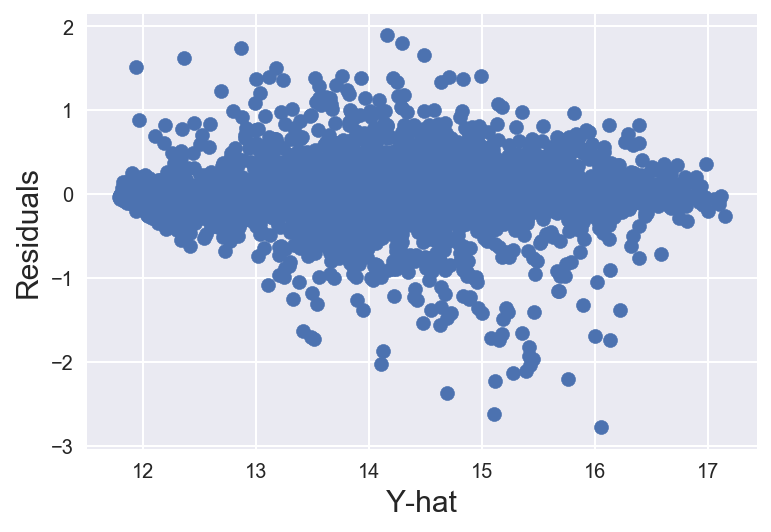

In [71]:
plt.scatter(y_pred, residual)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

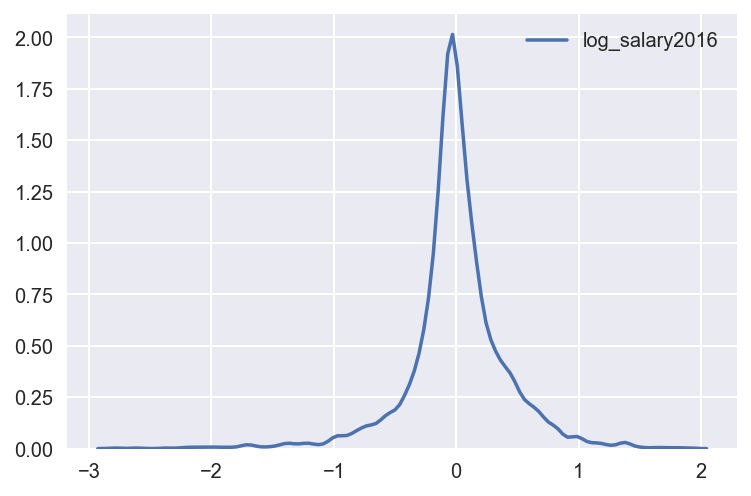

In [72]:
sns.kdeplot(residual)
plt.show()

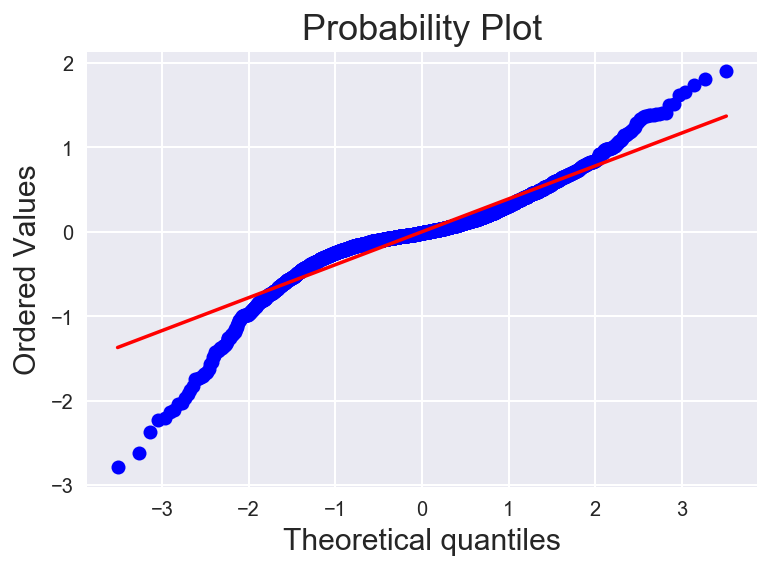

In [73]:
import pylab
import scipy.stats as scipystats
scipystats.probplot(residual, dist="norm", plot=pylab)
pylab.show()

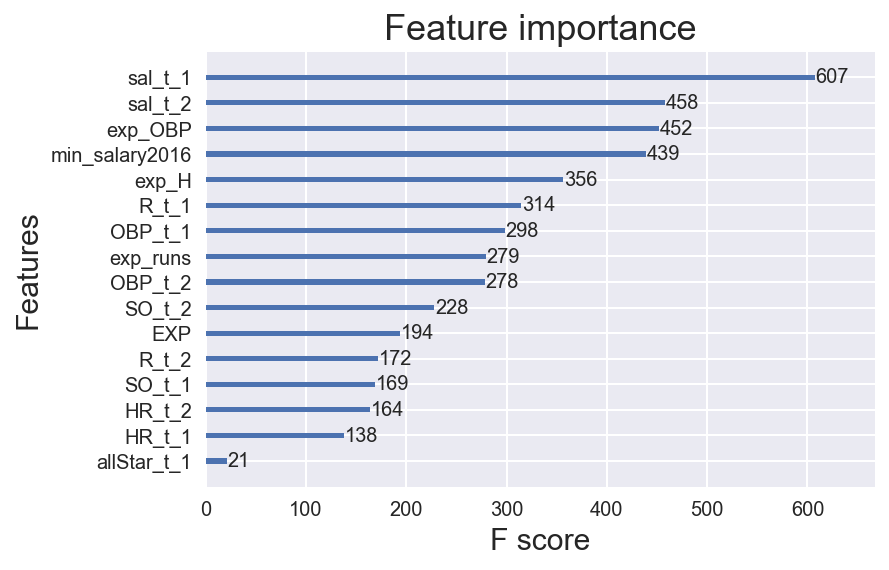

In [74]:
xgb.plot_importance(model_xgb)

Text(0,0.5,'Residuals')

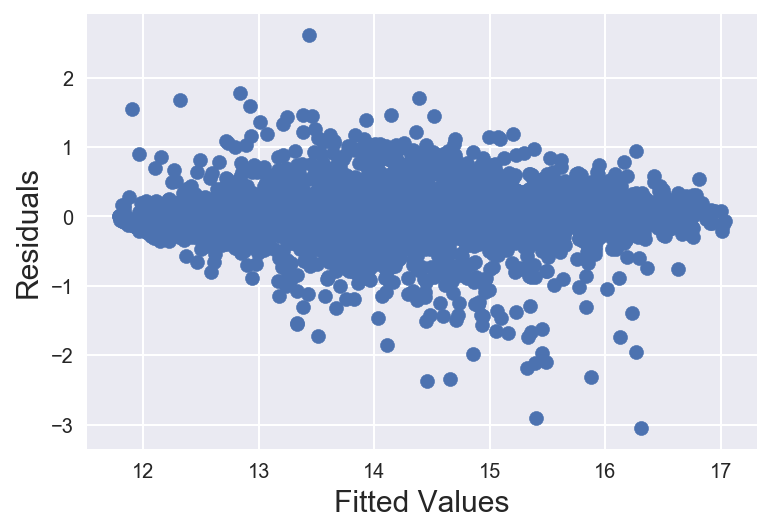

In [75]:
y_pred_gs = gs.predict(X_test)
res_gs = y_test - y_pred_gs
plt.scatter(y_pred_gs, res_gs)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

In [76]:
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(y_test, y_pred))

0.4101871821785593

In [77]:
# Second XGBoost model for Batting Salary dataset - only include 1 lag and include everything

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5, random_state=7)

model_xgb_lag1 = XGBRegressor(objective='reg:linear',
                         n_estimators=500,
                         max_depth=6,
                         learning_rate = 0.08,
                         colsample_bytree=1,
                         subsample = .8,
                         gamma = 1,
                         min_child_weight=5,
                         nthreads=4,
                         seed=123,
                         eval_metric="rmse")



results_lag1 = cross_val_score(model_xgb_lag1, X_train_lag1, y_train_lag1, cv=kfold)

print(results_lag1)

model_xgb_lag1.fit(X_train_lag1, y_train_lag1)


# make predictions for test data
y_pred_lag1 = model_xgb_lag1.predict(X_test_lag1)

print("Score_XGB:", model_xgb_lag1.score(X_test_lag1, y_test_lag1))


[0.89611637 0.8964671  0.89947587 0.88043623 0.88920829]
Score_XGB: 0.8913508066547764


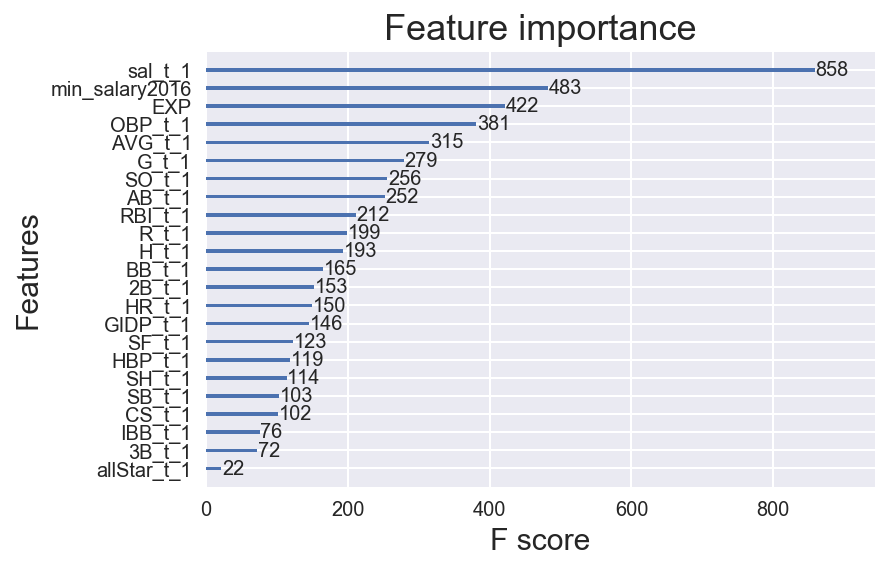

In [78]:
xgb.plot_importance(model_xgb_lag1)